Final project
Data science for electrical energy systems

Analyzing Electricity Market data using Machine Learning

The electricity market is influenced by various factors such as demand, renewable energy generation, weather conditions, and fuel prices. Accurate forecasting and analysis are crucial for market participants to optimize operations and make informed decisions.

Objective Work with Spanish historical electricity market data (find it on the ESIOS-REE webpage) to: • Supervised Learning (Regression): Predict the day-ahead spot electricity price in Spain. • Unsupervised Learning (Clustering): Group daily electricity price profiles into clusters to identify patterns. • Principal Component Analysis (PCA): Reduce data dimensionality and test its effect on your models. Tasks and guidelines

TASK 1) EDA: Exploratory Data Analysis (EDA) of potential input variables for your forecasting model.

TASK 2) Develop a machine learning model (supervised) to forecast the day ahead electricity price in Spain.
To obtain the target data, access the Esios website and download historical spot electricity prices. Possible input data can also be searched on this website. Some general guidelines for developing your model are detailed below. 1) Understand your data set. Use descriptive statistics and data visualization tools.

2) Data analysis of the data. Important! Prepare your dataset. Clean it and transform it, if needed.

3) Think about possible feature selection for your model.

4) Split the dataset into training and test.

5) Train your model using different ML.

6) Evaluate your model, adjust hyperparameters and retrain it if needed +.

7) Validate your model using the following regression metrics: RMSE, MAE and R2.

TASK 3) Create a clustering model to group the daily SPOT electricity price profiles in different clusters.
Use two clustering techniques (e.g., K-means, hierarchical clustering, DBSCAN…) to identify patterns or segments in the data based on historical electricity prices and other features, if necessary. Compare the results. Are they similar?

TASK 4) Test the regression and clustering methods using PCA Submission Requirements: Jupyter Notebook: • Include all your code for data analysis, model development, and evaluation. Inside this file, SEPARATE the different Tasks. • Ensure the notebook is well-organized with clear explanations and comments. Report (PDF): • Summarize your methodology, findings, and conclusions. It should have an index and sections explaining the main key findings. Include key visualizations and tables. • Discuss any challenges faced and how you addressed them.

Deadline: Final Report to be submitted before the end of the day on December 20th. Be sure to cite external resources or libraries you use. Your work should be original and reflect your understanding of machine learning concepts applied to real-world data.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import io
import plotly.graph_objects as go
import holidays

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from joblib import dump

import warnings
warnings.filterwarnings("ignore")

In [4]:
MarginalPriceDay22_24 = pd.read_csv('data/export_MarginalPriceDayAheadMarket_2024-10-11_17_28.csv',delimiter=';')

# Casting
print(MarginalPriceDay22_24.nunique())
MarginalPriceDay22_24.drop(['id', 'name', 'geoid', 'geoname'], axis=1, inplace = True)
MarginalPriceDay22_24['datetime'] = pd.to_datetime(MarginalPriceDay22_24['datetime'], errors='coerce', utc=True)

id              1
name            1
geoid           1
geoname         1
value        7710
datetime    17568
dtype: int64


In [5]:
extraData = pd.read_excel('data/Extra_data.xlsx')

# Drop columna Demand
extraData = extraData.drop(columns=['Demand [MWh]'])

In [6]:
# Merge MarginalPriceDay22_24 and extraData
dataset = pd.merge(MarginalPriceDay22_24, extraData, left_index=True, right_index=True)
dataset = dataset.rename(columns={'value': 'target'})

In [7]:
# Lags
dataset['target-1'] = dataset['target'].shift(24)
dataset['target-2'] = dataset['target'].shift(24*2)
dataset['target-3'] = dataset['target'].shift(24*3)
dataset['target-4'] = dataset['target'].shift(24*4)
dataset['target-5'] = dataset['target'].shift(24*5)
dataset['target-6'] = dataset['target'].shift(24*6)
dataset['target-7'] = dataset['target'].shift(24*7)
dataset['target-14'] = dataset['target'].shift(24*14)
dataset['target-31'] = dataset['target'].shift(24*31)

dataset['Wind Generation [MWh]-1'] = dataset['Wind Generation [MWh]'].shift(24)

dataset['Natural Gas Price [€/MWh]-1'] = dataset['Natural Gas Price [€/MWh]'].shift(24)

dataset.dropna(inplace=True)

# EDA

In [8]:
dataset.describe()

target  Wind Generation [MWh]  Solar Generation [MWh]  \
count  16791.000000           16791.000000            16791.000000   
mean      77.521338            7066.063885             4283.899297   
std       47.656703            4181.216820             5492.869913   
min       -2.000000             571.800000                0.000000   
25%       39.510000            3680.750000                0.000000   
50%       84.200000            6264.500000              344.500000   
75%      111.645000            9742.150000             8837.650000   
max      280.000000           20879.300000            19526.500000   

       Solar Thermal Generation [MW]  Natural Gas Price [€/MWh]  \
count                   16791.000000                16791.00000   
mean                      509.059619                   40.92739   
std                       593.643407                   18.59423   
min                         0.000000                   22.73000   
25%                        23.650000                   30.38000   
50%                       258.675000                   35.13000   
75%                       756.812500                   43.17000   
max                      2151.525000                  138.62000   

       Import Portugal [MW]  Import Morroco [MW]  Import France [MW]  \
count          16791.000000         16791.000000        16791.000000   
mean            3083.837889           584.575070         2720.743077   
std              496.577888            53.359414          620.754318   
min              450.000000           400.000000            0.000000   
25%             2781.000000           600.000000         2400.000000   
50%             3060.000000           600.000000         2682.000000   
75%             3384.000000           600.000000         3237.000000   
max             4680.000000           600.000000         3838.000000   

       Export Portugal [MW]  Export Morroco [MW]  ...      target-2  \
count          16791.000000         16791.000000  ...  16791.000000   
mean            3589.012090           857.753558  ...     77.523495   
std              623.774584           144.636585  ...     47.704016   
min              700.000000             0.000000  ...     -2.000000   
25%             3150.000000           900.000000  ...     39.510000   
50%             3600.000000           900.000000  ...     84.120000   
75%             4095.000000           900.000000  ...    111.505000   
max             5175.000000           900.000000  ...    280.000000   

           target-3      target-4      target-5      target-6      target-7  \
count  16791.000000  16791.000000  16791.000000  16791.000000  16791.000000   
mean      77.522975     77.522394     77.511100     77.578575     77.635990   
std       47.713954     47.731458     47.747585     47.773985     47.759675   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       39.510000     39.500000     39.500000     39.500000     39.555000   
50%       84.140000     84.140000     84.120000     84.200000     84.250000   
75%      111.445000    111.415000    111.415000    111.505000    111.550000   
max      280.000000    280.000000    280.000000    280.000000    280.000000   

          target-14     target-31  Wind Generation [MWh]-1  \
count  16791.000000  16791.000000             16791.000000   
mean      78.223201     79.709707              7063.547383   
std       48.243898     49.826658              4183.050361   
min       -2.000000     -2.000000               571.800000   
25%       39.940000     40.000000              3674.900000   
50%       84.850000     85.330000              6264.500000   
75%      112.150000    113.720000              9742.150000   
max      280.000000    300.000000             20879.300000   

       Natural Gas Price [€/MWh]-1  
count                 16791.000000  
mean                     40.986189  
std                      18.654986  
min                      22.730000  
25%                      30.38000

In [9]:
dataset.isna().sum()

target                           0
datetime                         0
Wind Generation [MWh]            0
Solar Generation [MWh]           0
Solar Thermal Generation [MW]    0
Natural Gas Price [€/MWh]        0
Import Portugal [MW]             0
Import Morroco [MW]              0
Import France [MW]               0
Export Portugal [MW]             0
Export Morroco [MW]              0
Export France [MW]               0
target-1                         0
target-2                         0
target-3                         0
target-4                         0
target-5                         0
target-6                         0
target-7                         0
target-14                        0
target-31                        0
Wind Generation [MWh]-1          0
Natural Gas Price [€/MWh]-1      0
dtype: int64

In [10]:
dataset.shape

(16791, 23)

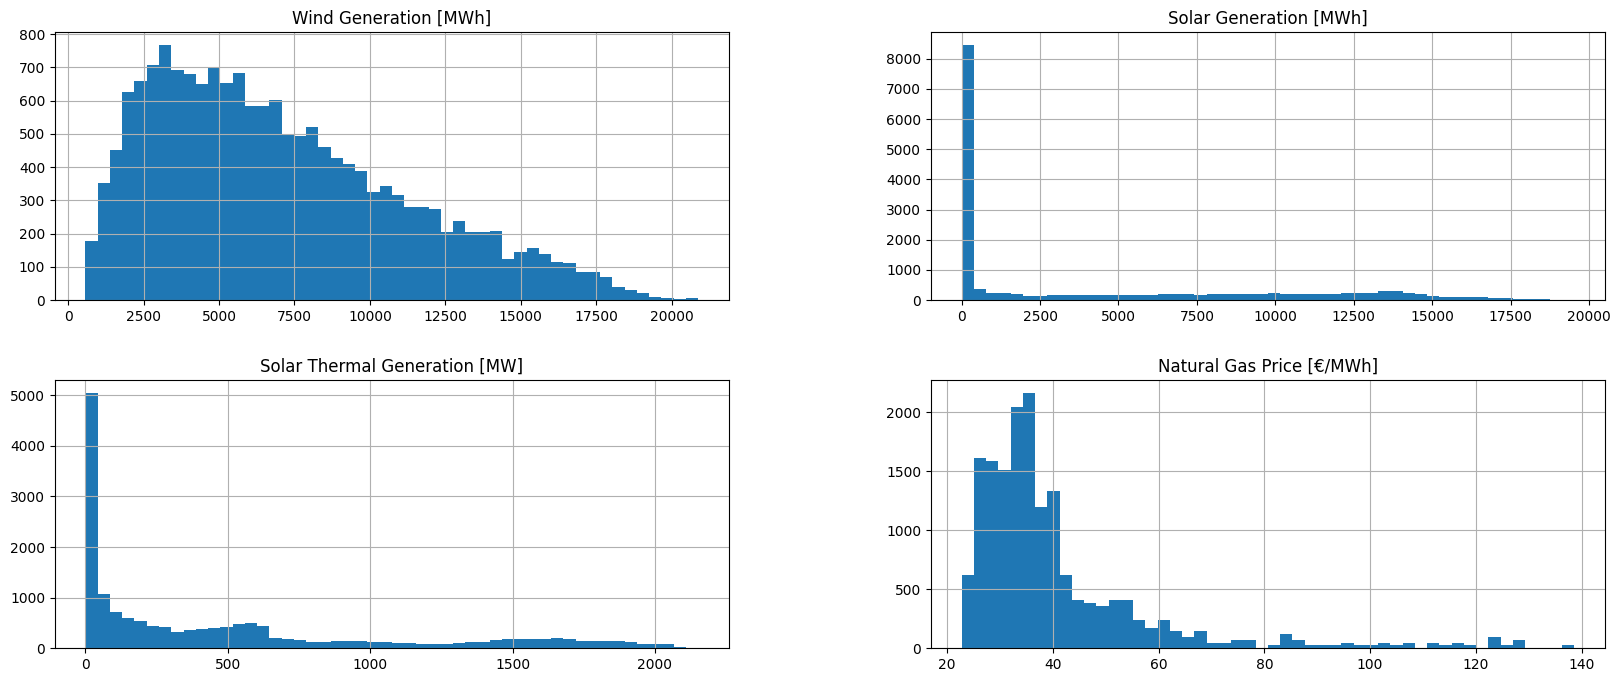

In [11]:
# Histograms
dataset[['Wind Generation [MWh]', 'Solar Generation [MWh]',
       'Solar Thermal Generation [MW]', 'Natural Gas Price [€/MWh]']].hist(bins=50, figsize=(20,8))
plt.show()

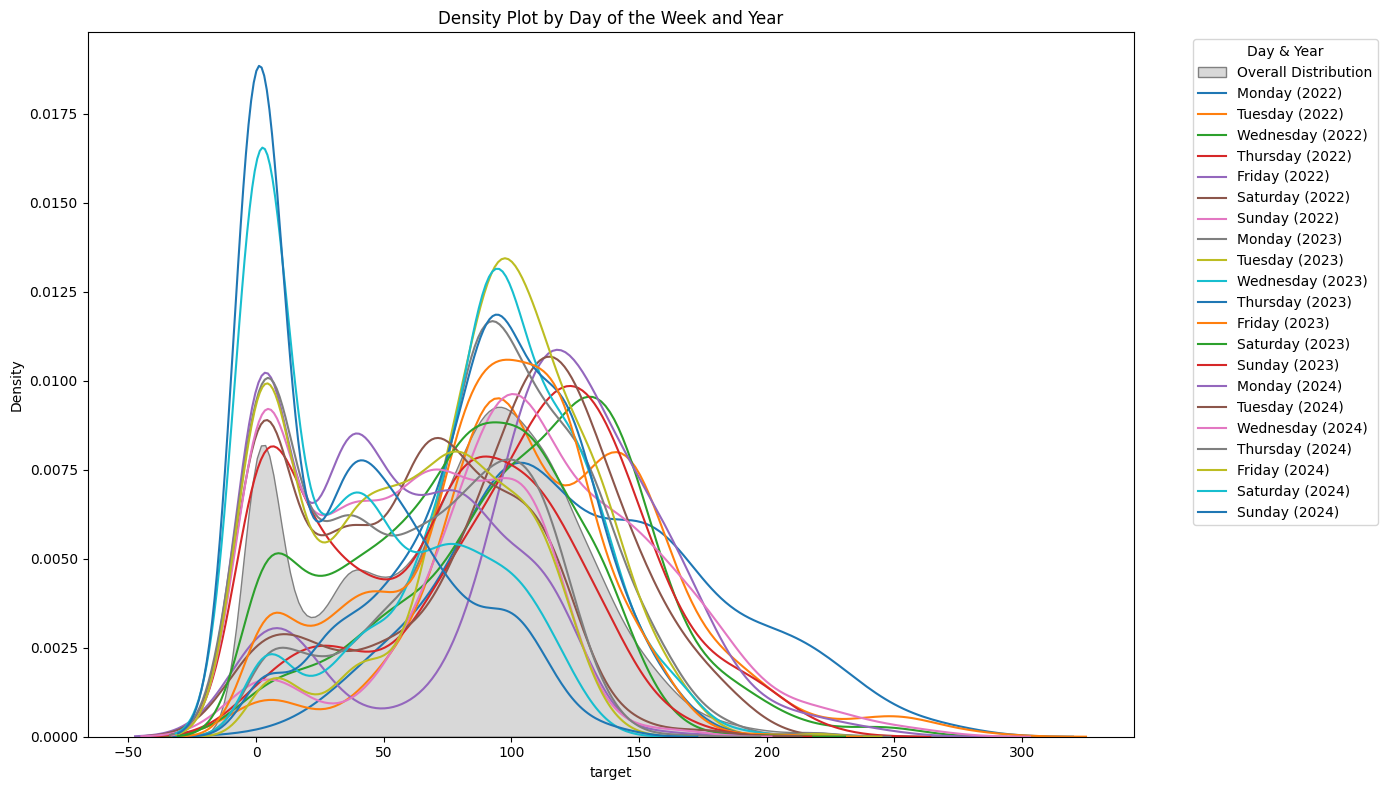

In [12]:
dataset00 = dataset.copy()
dataset00['datetime'] = pd.to_datetime(dataset00['datetime'])

# Create columns
dataset00['day_name'] = dataset00['datetime'].dt.day_name()
dataset00['year'] = dataset00['datetime'].dt.year

plt.figure(figsize=(14, 8))

# Density Graph
sns.kdeplot(data=dataset00, x='target', fill=True, color='gray', alpha=0.3, label='Overall Distribution')
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

years = dataset00['year'].unique()
for year in sorted(years):
    for day in days_of_week:
        sns.kdeplot(
            data=dataset00[(dataset00['day_name'] == day) & (dataset00['year'] == year)],
            x='target',
            fill=False,
            common_norm=False,
            label=f'{day} ({year})'
        )
plt.title('Density Plot by Day of the Week and Year')
plt.xlabel('target')
plt.ylabel('Density')
plt.legend(title='Day & Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Figure_Density1.png', format='png', dpi=300)
plt.show()

In [13]:
dataset00 = dataset.copy()
dataset00['datetime'] = pd.to_datetime(dataset00['datetime'])
dataset00['day_name'] = dataset00['datetime'].dt.day_name()
dataset00['year'] = dataset00['datetime'].dt.year
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
years = sorted(dataset00['year'].unique())  # Años únicos ordenados

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=dataset00['target'],
    histnorm='probability density',
    name='Overall Distribution',
    opacity=0.5,
    visible=True
))

for year in years:
    for day in days_of_week:
        filtered_data = dataset00[(dataset00['day_name'] == day) & (dataset00['year'] == year)]
        if not filtered_data.empty:
            fig.add_trace(go.Histogram(
                x=filtered_data['target'],
                histnorm='probability density',
                name=f'{day} ({year})',
                opacity=0.5,
                visible=False
            ))

buttons = []
buttons.append(dict(label='Show All',
                    method='update',
                    args=[{'visible': [True] * len(fig.data)},  # Hacer visibles todas las trazas
                          {'title': 'All Distributions Shown'}]))

for day in days_of_week:
    for year in years:
        visibility = [trace.name == f'{day} ({year})' for trace in fig.data]
        visibility[0] = True
        buttons.append(dict(label=f'{day} ({year})',
                            method='update',
                            args=[{'visible': visibility},
                                  {'title': f'{day} ({year}) Distribution'}]))

fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=1.15,
        xanchor='right',
        y=1,
        yanchor='top'
    )]
)

fig.update_layout(
    title='Interactive Density Plot by Day and Year',
    xaxis_title='Target',
    yaxis_title='Density',
    template='plotly_white'
)

fig.show()

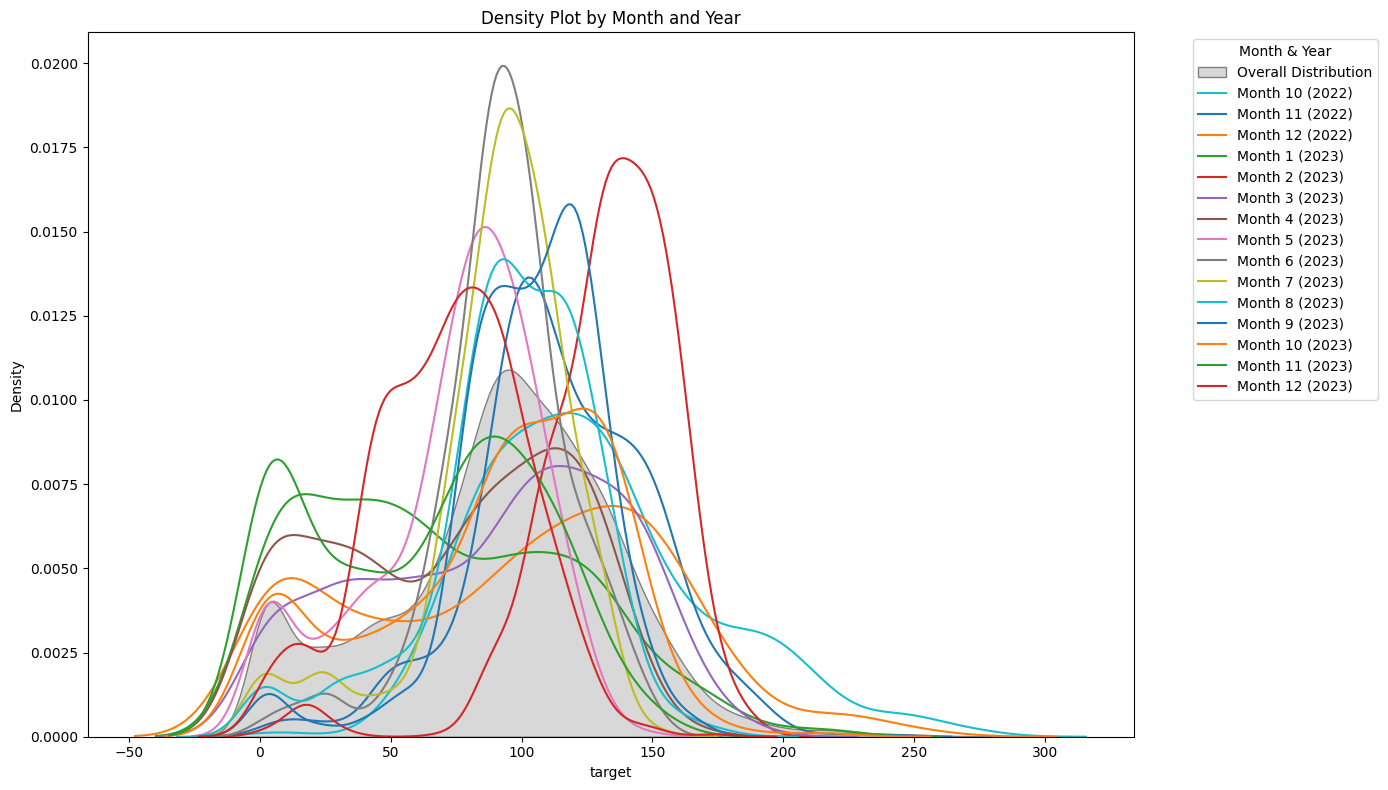

In [14]:
dataset00 = dataset.copy()

# Filtered density plot
dataset00 = dataset00[dataset00['datetime'] <= '2024-01-01']

dataset00['datetime'] = pd.to_datetime(dataset00['datetime'])
dataset00['month'] = dataset00['datetime'].dt.month
dataset00['year'] = dataset00['datetime'].dt.year
plt.figure(figsize=(14, 8))
sns.kdeplot(data=dataset00, x='target', fill=True, color='gray', alpha=0.3, label='Overall Distribution')
months = list(range(1, 13))

years = dataset00['year'].unique()
for year in sorted(years):
    for month in months:
        sns.kdeplot(
            data=dataset00[(dataset00['month'] == month) & (dataset00['year'] == year)],
            x='target',
            fill=False,
            common_norm=False,
            label=f'Month {month} ({year})'
        )

plt.title('Density Plot by Month and Year')
plt.xlabel('target')  # Ajusta esto al nombre de tu columna
plt.ylabel('Density')
plt.legend(title='Month & Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Figure_Density2.png', format='png', dpi=300)
plt.show()

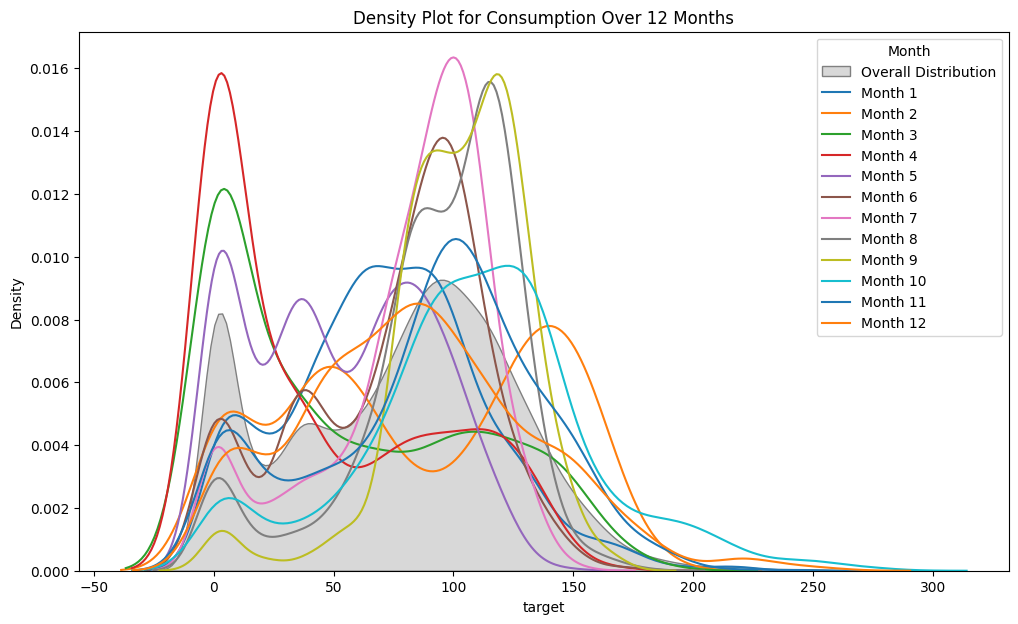

In [15]:
# Density plot by month

dataset00 = dataset.copy()

dataset00['datetime'] = pd.to_datetime(dataset00['datetime'])
dataset00['month'] = dataset00['datetime'].dt.month
plt.figure(figsize=(12, 7))
sns.kdeplot(data=dataset00, x='target', fill=True, color='gray', alpha=0.3, label='Overall Distribution')

for month in range(1, 13):
    sns.kdeplot(
        data=dataset00[dataset00['month'] == month],
        x='target',
        fill=False,
        common_norm=False,
        label=f'Month {month}'
    )

plt.title('Density Plot for Consumption Over 12 Months')
plt.xlabel('target')
plt.ylabel('Density')
plt.legend(title='Month')
plt.savefig('Figure_Density3.png', format='png', dpi=300)
plt.show()

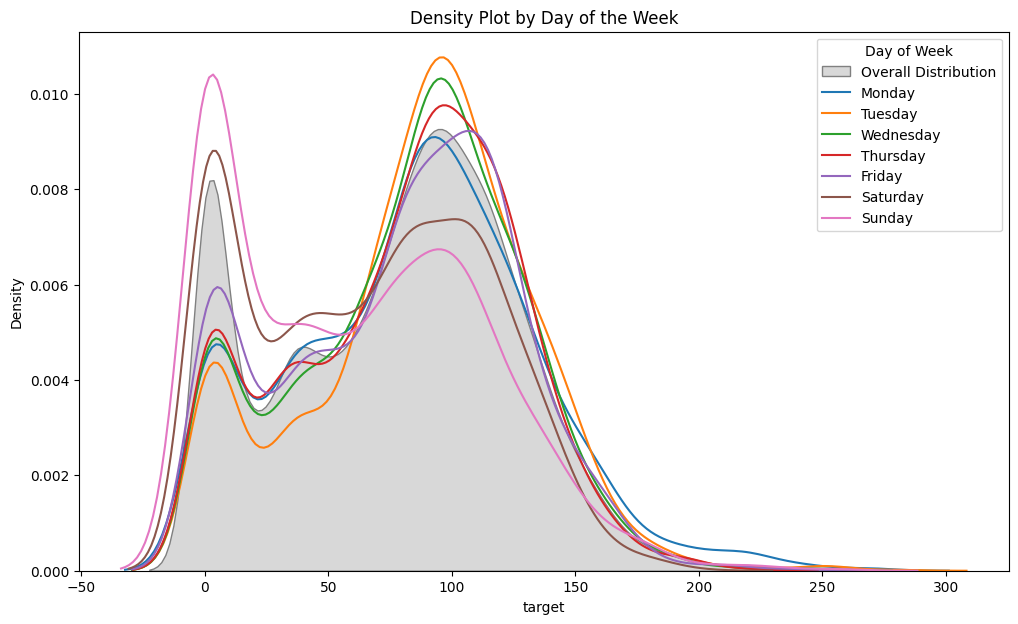

In [16]:
# Density plot by day
dataset00 = dataset.copy()

dataset00['datetime'] = pd.to_datetime(dataset00['datetime'])
dataset00['day_name'] = dataset00['datetime'].dt.day_name()
plt.figure(figsize=(12, 7))
sns.kdeplot(data=dataset00, x='target', fill=True, color='gray', alpha=0.3, label='Overall Distribution')
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days_of_week:
    sns.kdeplot(
        data=dataset00[dataset00['day_name'] == day],
        x='target',
        fill=False,
        common_norm=False,
        label=day
    )

plt.title('Density Plot by Day of the Week')
plt.xlabel('target')
plt.ylabel('Density')
plt.legend(title='Day of Week')
plt.savefig('Figure_Density4.png', format='png', dpi=300)
plt.show()

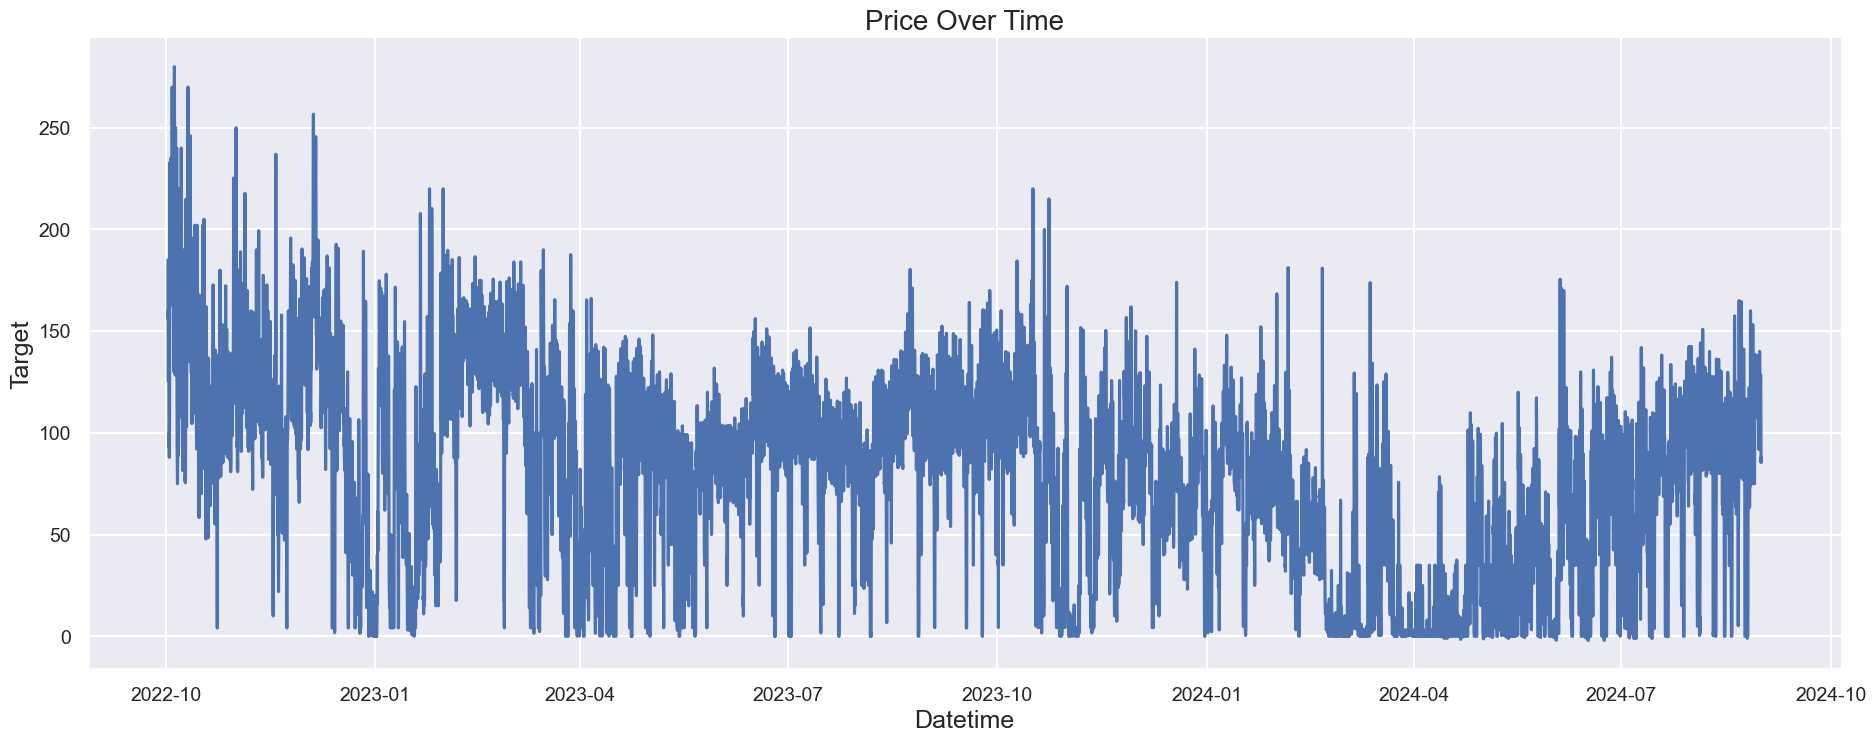

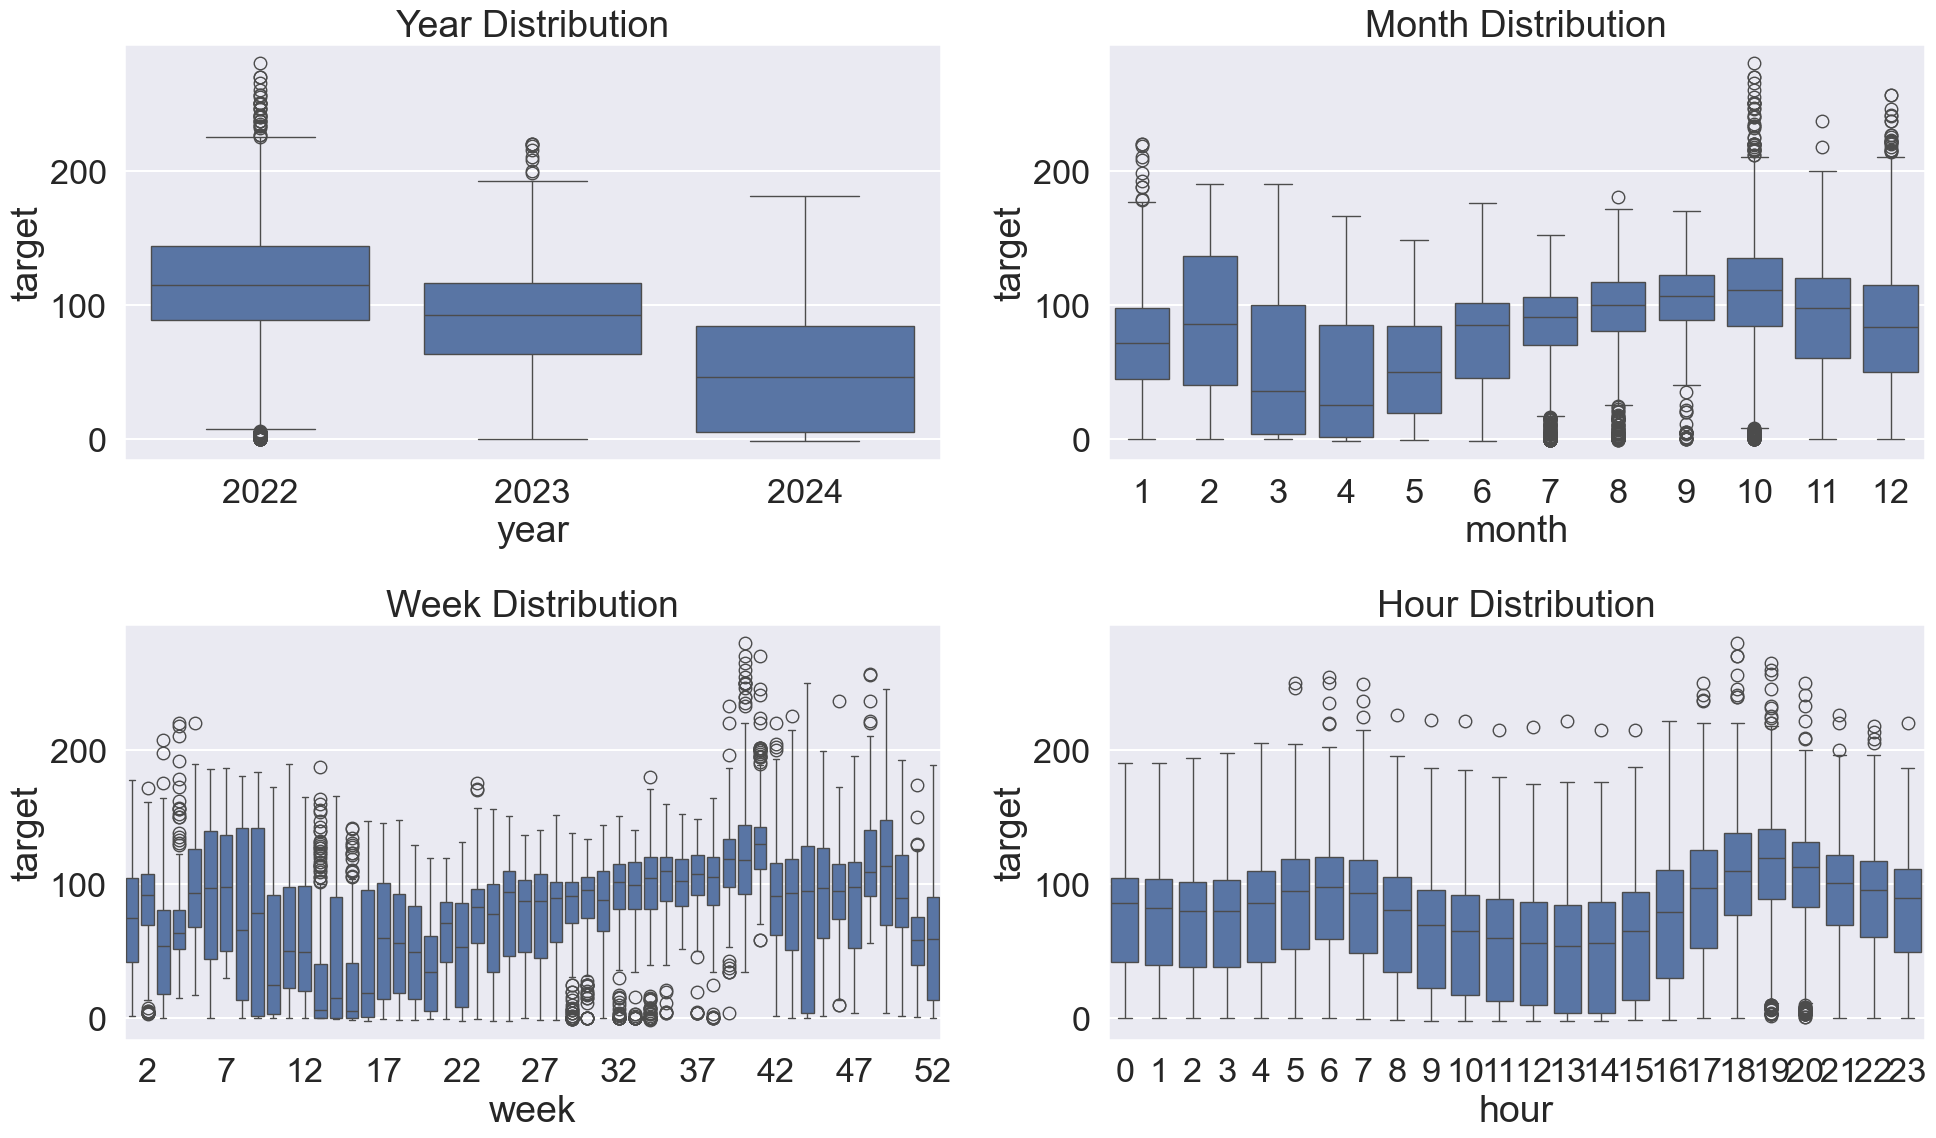

In [17]:
dataset_00 = dataset.copy()

dataset_00['year'] = dataset_00['datetime'].dt.year
dataset_00['month'] = dataset_00['datetime'].dt.month
dataset_00['week'] = dataset_00['datetime'].dt.isocalendar().week
dataset_00['hour'] = dataset_00['datetime'].dt.hour

# Price over time
sns.set(rc={'figure.figsize': (25, 8)})
sns.set_context("talk", font_scale=1.5)
sns.relplot(x='datetime', y='target', data=dataset_00, kind='line', height=8, aspect=2.5)
plt.title('Price Over Time', fontsize=20)
plt.xlabel('Datetime', fontsize=18)
plt.ylabel('Target', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('Figure_Target.png', format='png', dpi=300)
plt.show()

# Boxplots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # 2x2

sns.boxplot(x='year', y='target', data=dataset_00, ax=axes[0, 0])
axes[0, 0].set_title('Year Distribution')

sns.boxplot(x='month', y='target', data=dataset_00, ax=axes[0, 1])
axes[0, 1].set_title('Month Distribution')

sns.boxplot(x='week', y='target', data=dataset_00, ax=axes[1, 0])
axes[1, 0].set_title('Week Distribution')
ticks = list(range(1, 52, 5))
axes[1, 0].set_xticks(ticks)

sns.boxplot(x='hour', y='target', data=dataset_00, ax=axes[1, 1])
axes[1, 1].set_title('Hour Distribution')

plt.tight_layout()
plt.savefig('Figure_Boxplots.png', format='png', dpi=300)
plt.show()

In [18]:
dataset = dataset.sort_values('datetime')

# Rolling mean for the last 7, 14 and 31 days
dataset['targetmean_7day'] = dataset['target'].rolling(window=7, min_periods=1).mean()
dataset['targetmean_14day'] = dataset['target'].rolling(window=14, min_periods=1).mean()
dataset['targetmean_31day'] = dataset['target'].rolling(window=31, min_periods=1).mean()

# Rolling max for the last 3, 7 and 10 days
dataset['targetmax_3day'] = dataset['target'].rolling(window=3, min_periods=1).max()
dataset['targetmax_7day'] = dataset['target'].rolling(window=7, min_periods=1).max()
dataset['targetmax_10day'] = dataset['target'].rolling(window=10, min_periods=1).max()

# Rolling min for the last 3, 7 and 10 days
dataset['targetmin_3day'] = dataset['target'].rolling(window=3, min_periods=1).min()
dataset['targetmin_7day'] = dataset['target'].rolling(window=7, min_periods=1).min()
dataset['targetmin_10day'] = dataset['target'].rolling(window=10, min_periods=1).min()

# Add weekends and holidays
festivos_es = holidays.Spain(years=dataset['datetime'].dt.year.unique())
dataset['isweekend'] = dataset['datetime'].dt.dayofweek.isin([5, 6]).astype(int)
dataset['isweekend'] = dataset['isweekend'] | dataset['datetime'].dt.date.isin(festivos_es).astype(int)
dataset.dropna(inplace=True)

In [19]:
dataset.head(5)

target                  datetime  Wind Generation [MWh]  \
744  185.04 2022-10-01 22:00:00+00:00                 3034.8   
745  156.10 2022-10-01 23:00:00+00:00                 3221.8   
746  159.94 2022-10-02 00:00:00+00:00                 3633.3   
747  150.30 2022-10-02 01:00:00+00:00                 4025.8   
748  125.31 2022-10-02 02:00:00+00:00                 4252.3   

     Solar Generation [MWh]  Solar Thermal Generation [MW]  \
744                     0.0                        199.100   
745                     0.0                        157.825   
746                     0.0                        189.300   
747                     0.0                        165.575   
748                     0.0                        126.150   

     Natural Gas Price [€/MWh]  Import Portugal [MW]  Import Morroco [MW]  \
744                      75.29                2565.0                600.0   
745                      75.29                2565.0                600.0   
746                      75.29                2565.0                600.0   
747                      75.29                2565.0                600.0   
748                      75.29                2340.0                600.0   

     Import France [MW]  Export Portugal [MW]  ...  targetmean_7day  \
744               350.0                3960.0  ...       185.040000   
745               350.0                3960.0  ...       170.570000   
746               350.0                3960.0  ...       167.026667   
747               350.0                3960.0  ...       162.845000   
748              2899.0                3870.0  ...       155.338000   

     targetmean_14day  targetmean_31day  targetmax_3day  targetmax_7day  \
744        185.040000        185.040000          185.04          185.04   
745        170.570000        170.570000          185.04          185.04   
746        167.026667        167.026667          185.04          185.04   
747        162.845000        162.845000          159.94          185.04   
748        155.338000        155.338000          159.94          185.04   

     targetmax_10day  targetmin_3day  targetmin_7day  targetmin_10day  \
744           185.04          185.04          185.04           185.04   
745           185.04          156.10          156.10           156.10   
746           185.04          156.10          156.10           156.10   
747           185.04          150.30          150.30           150.30   
748           185.04          125.31          125.31           125.31   

     isweekend  
744          1  
745          1  
746          1  
747          1  
748          1  

[5 rows x 33 columns]

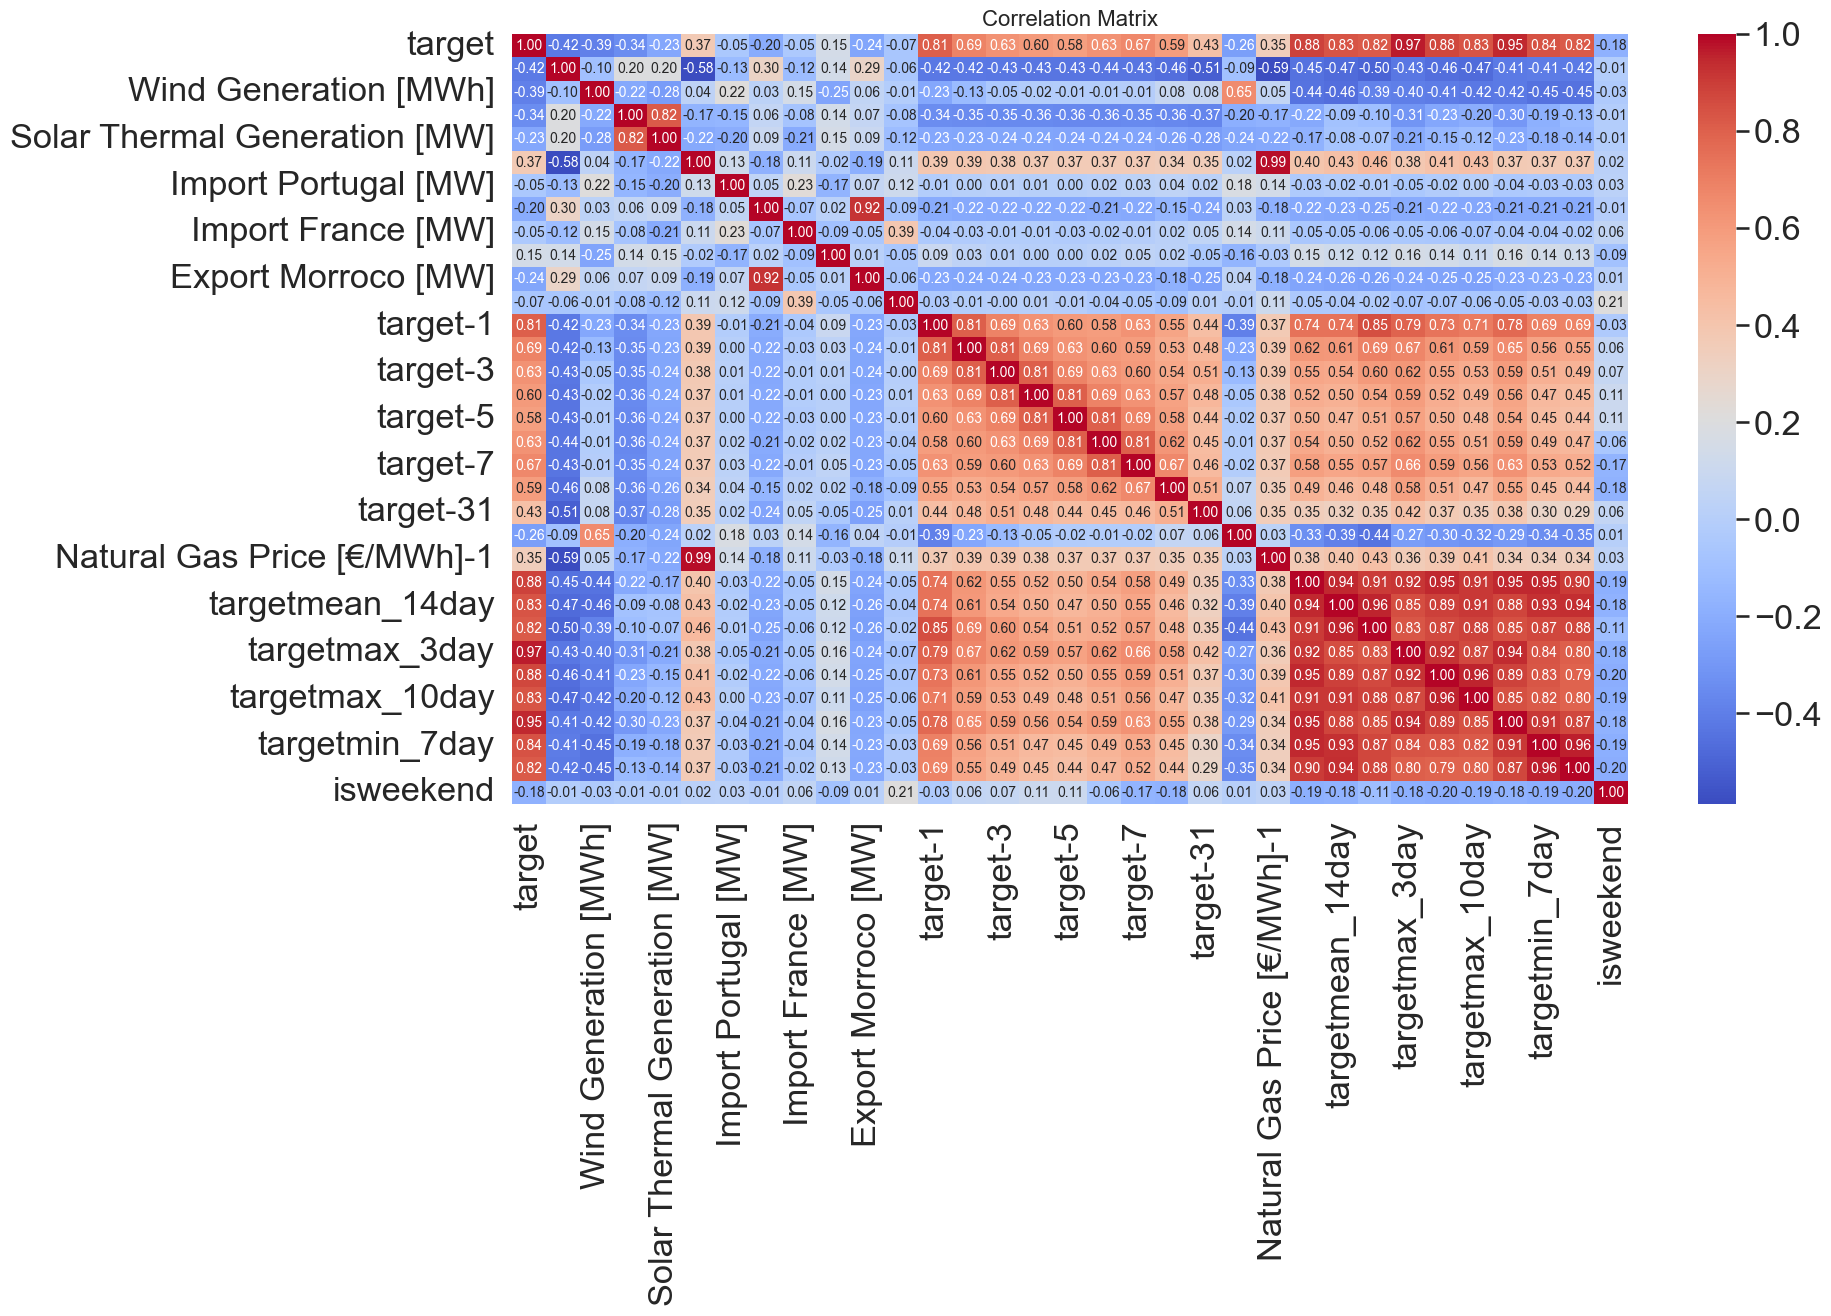

In [20]:
# Correlation
plt.figure(figsize=(18, 10))
# Crear un heatmap con valores numéricos dentro de cada celda
sns.heatmap(dataset.corr(), cmap="coolwarm", annot=True, fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=16)
plt.savefig('Figure_Correlation.png', format='png', dpi=300)
plt.show()

# Supervised Learning

In [21]:
### Enviroment ###
dataset_modelo = dataset.copy()

# Dataset model creation and data filtering
dataset_modelo = dataset_modelo[dataset_modelo['datetime'] <= '2024-01-01']

In [22]:
# Creamos el DATASET para el modelo:

### one-hot encoding ###

dataset_modelo['week'] = dataset_modelo['datetime'].dt.isocalendar().week
dataset_modelo['year'] = dataset_modelo['datetime'].dt.year
dataset_modelo['month'] = dataset_modelo['datetime'].dt.month
dataset_modelo.loc[:,'day_of_week'] = dataset_modelo['datetime'].dt.weekday
dataset_modelo.loc[:,'hour'] = dataset_modelo['datetime'].dt.hour

dataset_modelo = pd.get_dummies(dataset_modelo, columns=['year'], prefix='year',  dtype=float)
dataset_modelo = pd.get_dummies(dataset_modelo, columns=['week'], prefix='week',  dtype=float)
dataset_modelo = pd.get_dummies(dataset_modelo, columns=['month'], prefix='month',  dtype=float)
dataset_modelo = pd.get_dummies(dataset_modelo, columns=['day_of_week'], prefix='day_of_week',  dtype=float)
dataset_modelo = pd.get_dummies(dataset_modelo, columns=['hour'], prefix='hour',  dtype=float)

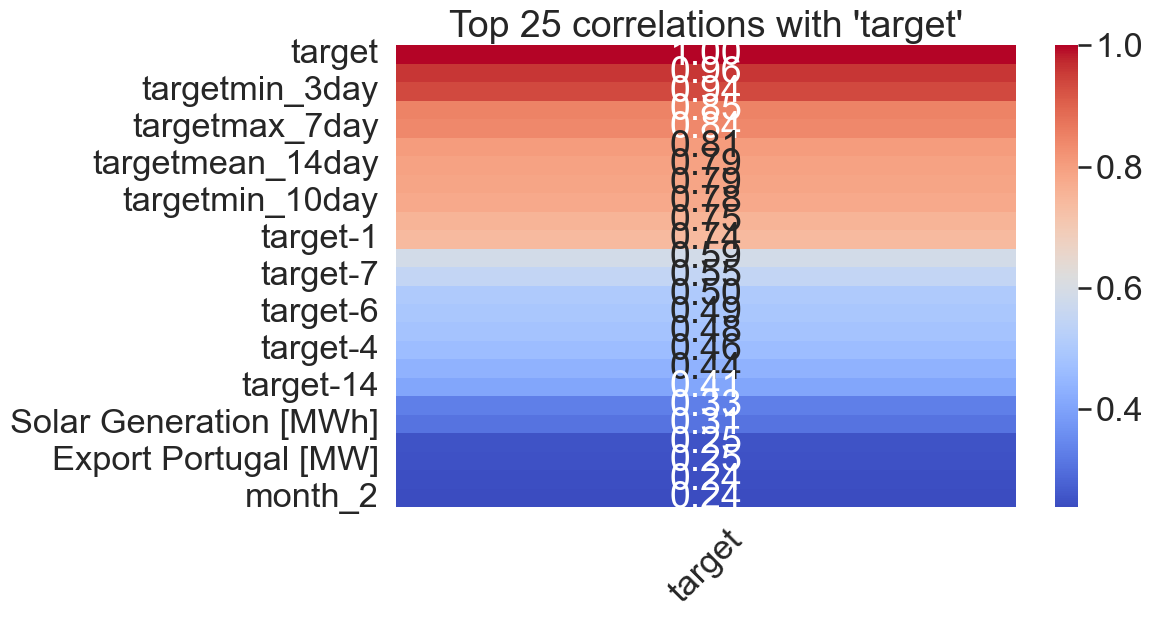

In [23]:
# Correlations DATASET MODELO
dataset_modelo['target'] = pd.to_numeric(dataset_modelo['target'], errors='coerce')
correlations = dataset_modelo.corr()

value_correlations = correlations[['target']]
sorted_correlations = correlations['target'].sort_values(ascending=False)

# Select the 25 highest correlations
top_correlations = sorted_correlations.abs().sort_values(ascending=False).head(25)

# Selected correlations graph
plt.figure(figsize=(10, 6))
sns.heatmap(top_correlations.to_frame(), cmap="coolwarm", annot=True, cbar=True, fmt=".2f")
plt.title("Top 25 correlations with 'target'")
plt.xticks(rotation=45)
plt.savefig('Figure_Top25_Correlations.png', format='png', dpi=300)
plt.show()

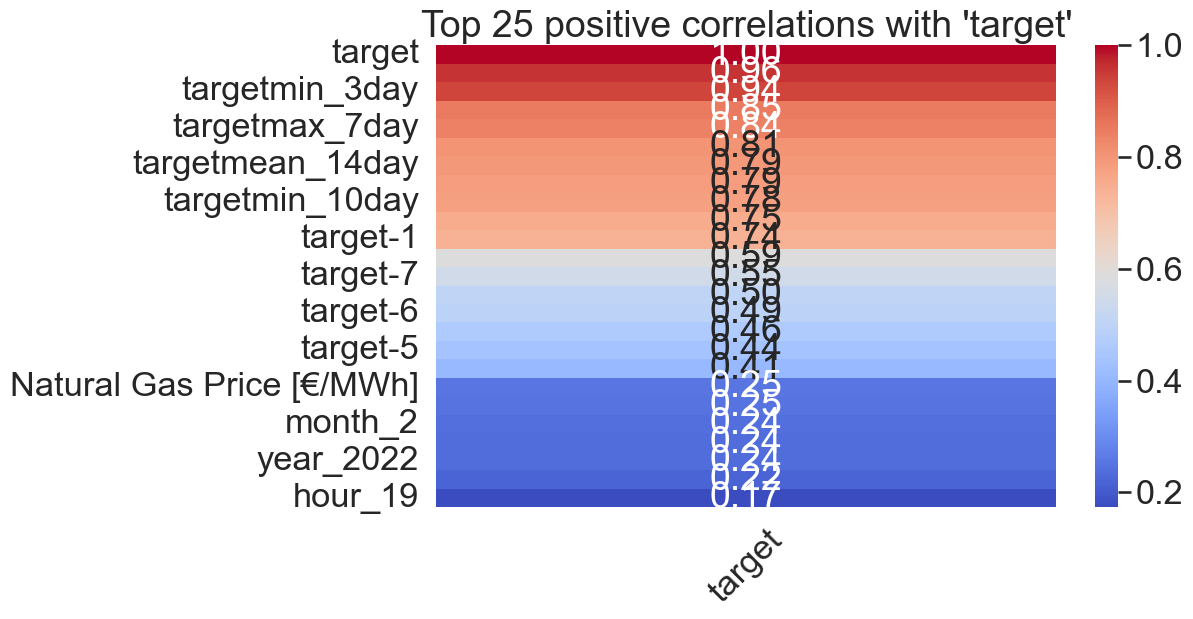

In [24]:
# Select the 25 highest positive correlations
positive_correlations = correlations['target'].sort_values(ascending=False).head(25)

# Selected positive correlations graph
plt.figure(figsize=(10, 6))
sns.heatmap(positive_correlations.to_frame(), cmap="coolwarm", annot=True, cbar=True, fmt=".2f")
plt.title("Top 25 positive correlations with 'target'")
plt.xticks(rotation=45)
plt.savefig('Figure_Top25_Positive_Correlations.png', format='png', dpi=300)
plt.show()

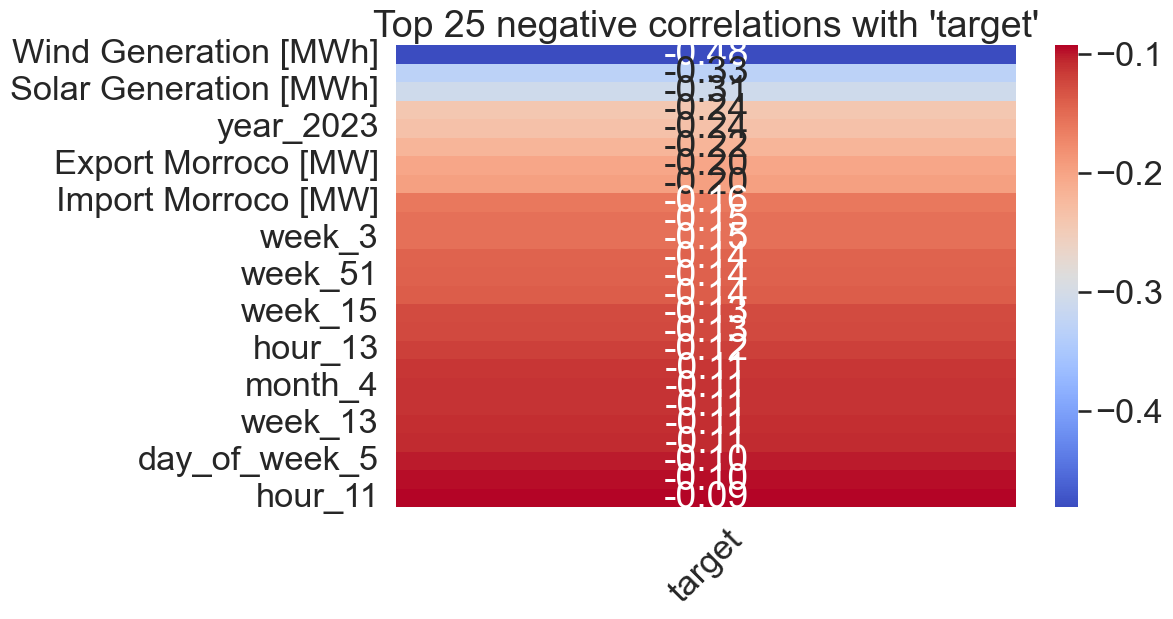

In [25]:
# Select the 25 lowest negative correlations
negative_correlations = correlations['target'].sort_values().head(25)

# Selected negative correlations graph
plt.figure(figsize=(10, 6))
sns.heatmap(negative_correlations.to_frame(), cmap="coolwarm", annot=True, cbar=True, fmt=".2f")
plt.title("Top 25 negative correlations with 'target'")
plt.xticks(rotation=45)
plt.savefig('Figure_Top25_Negative_Correlations.png', format='png', dpi=300)
plt.show()

In [26]:
# Divide data
X = dataset_modelo.drop(['datetime','target'], axis=1)
y = dataset_modelo['target']

test_size = 0.2
validation_size = 0.05

# Training + Validation + Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=False
)

# Training + Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=validation_size, shuffle=False
)

In [27]:
## MinMaxSCALER ##
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the validation and test data (do not fit again)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

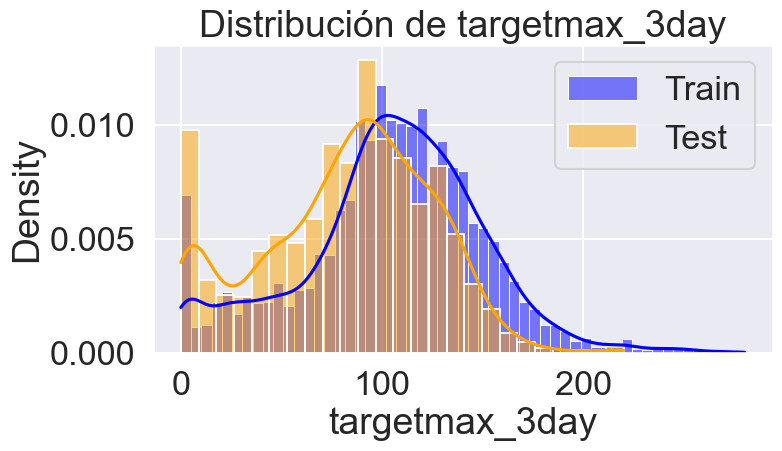

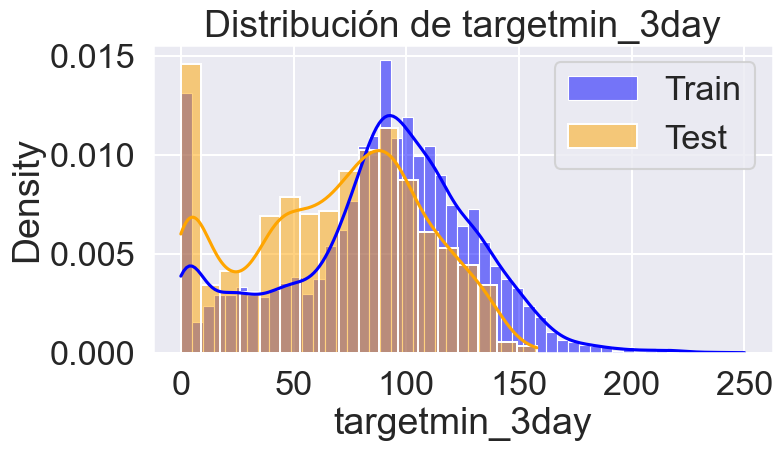

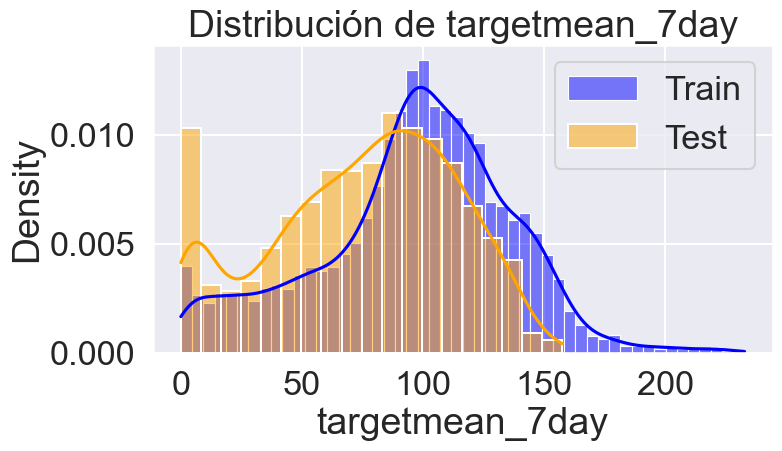

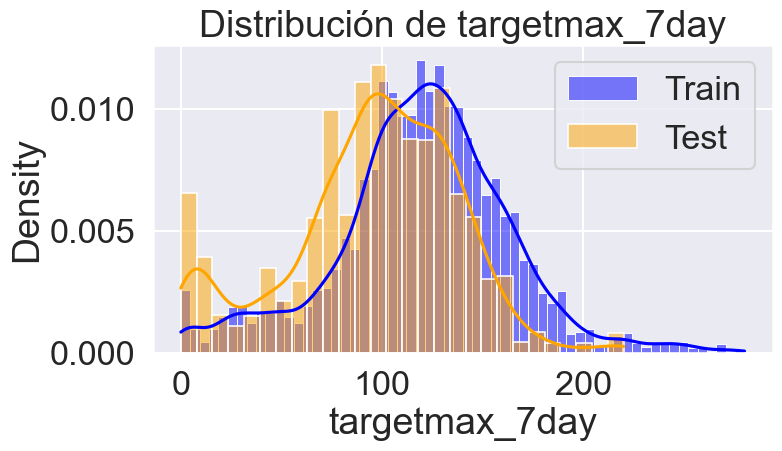

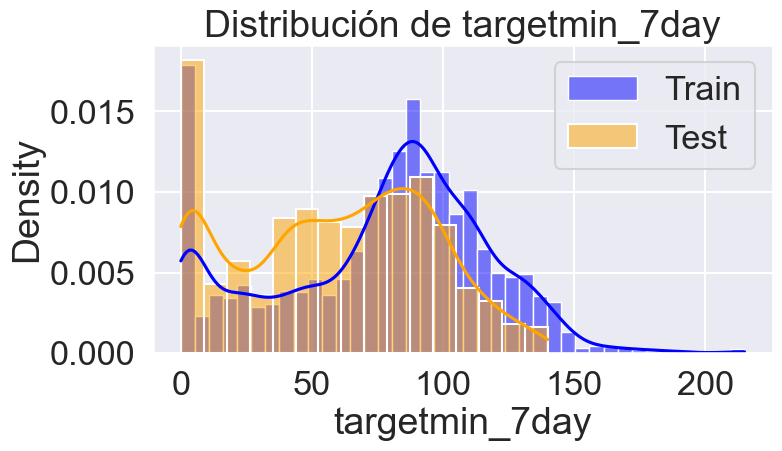

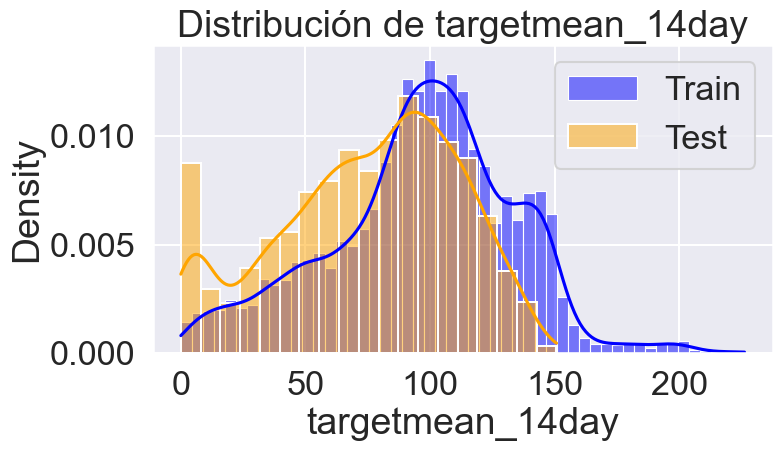

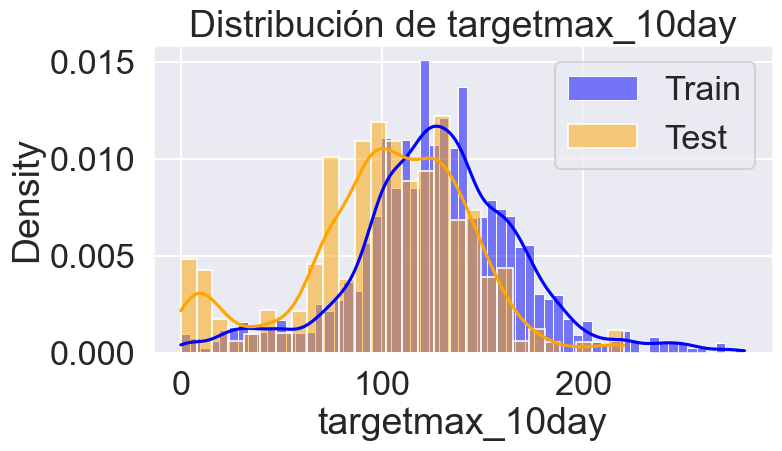

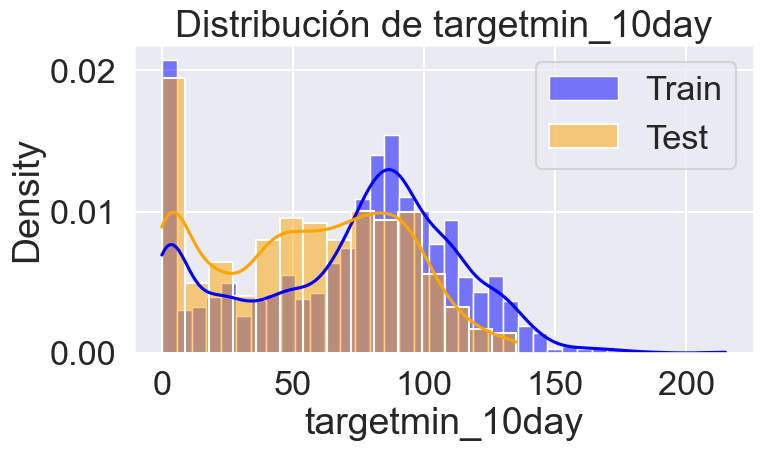

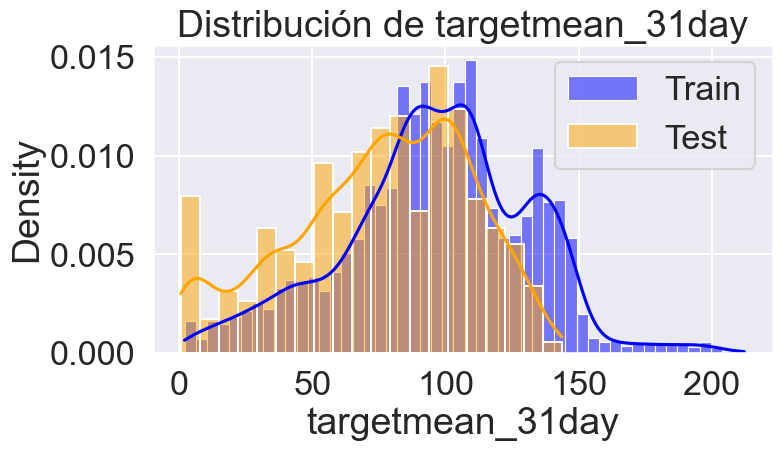

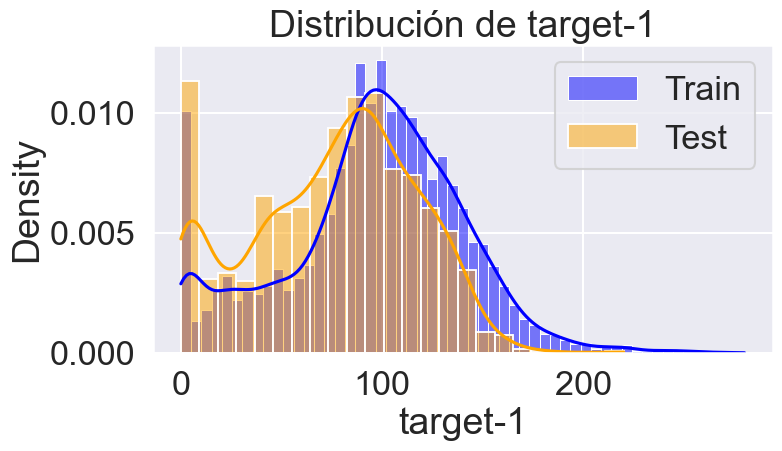

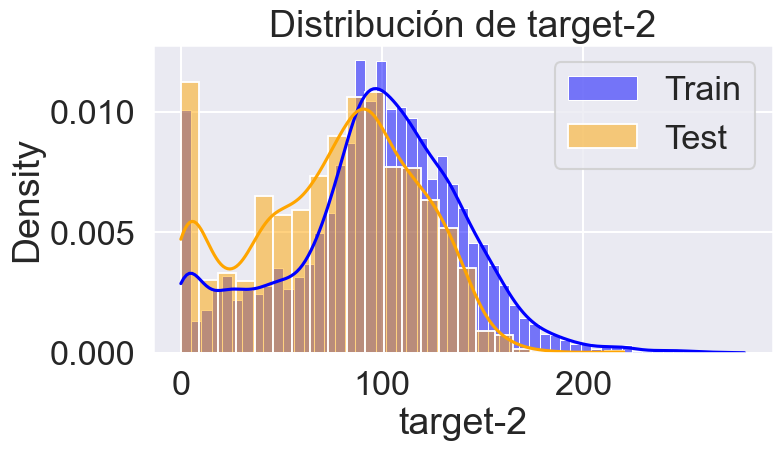

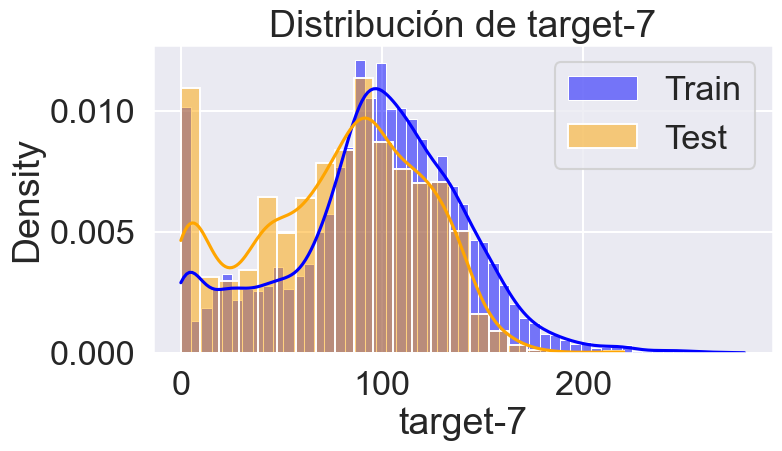

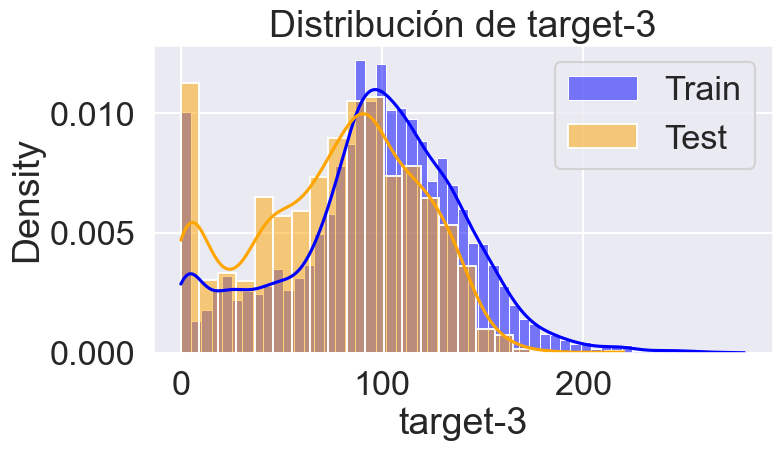

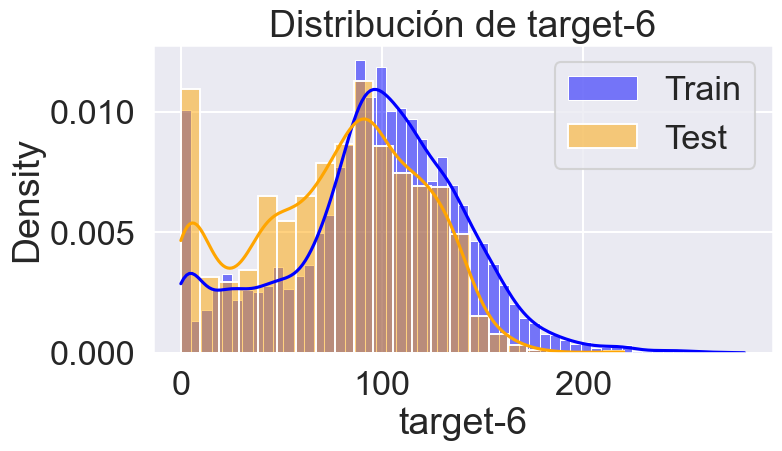

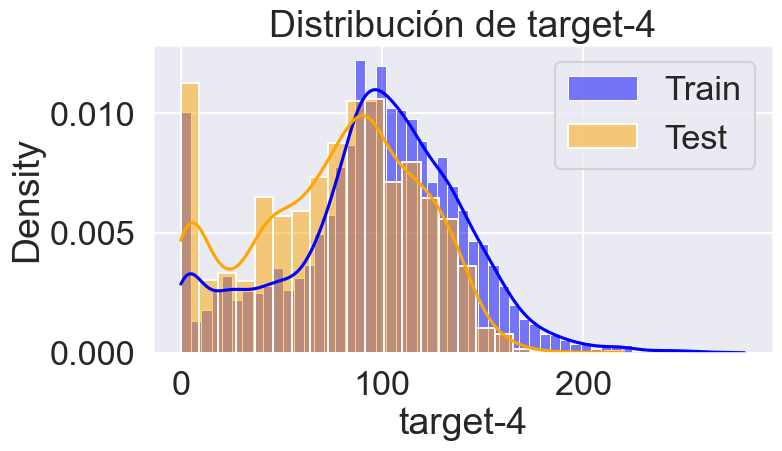

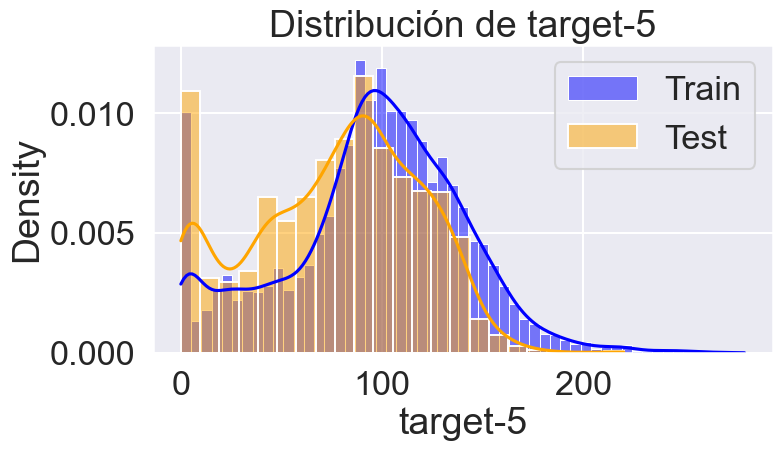

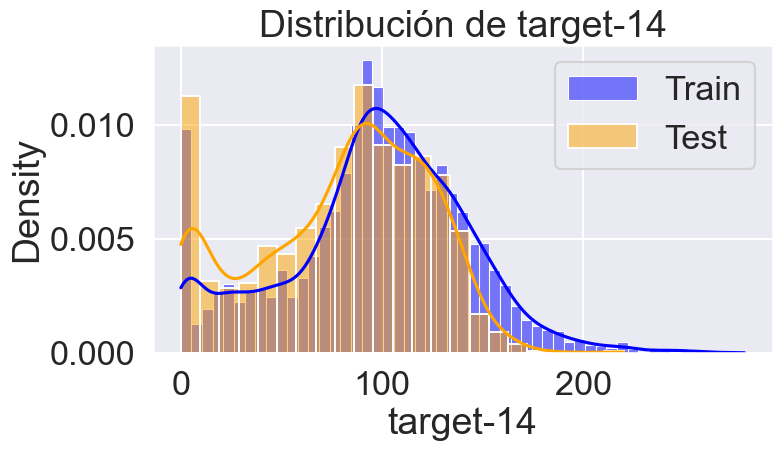

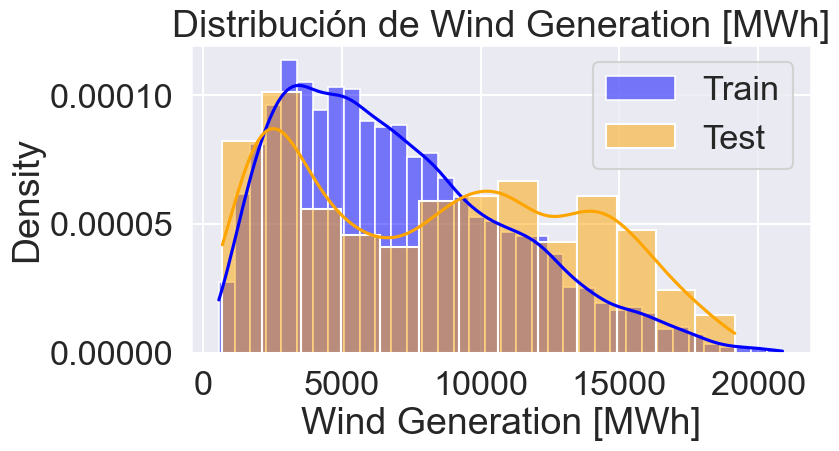

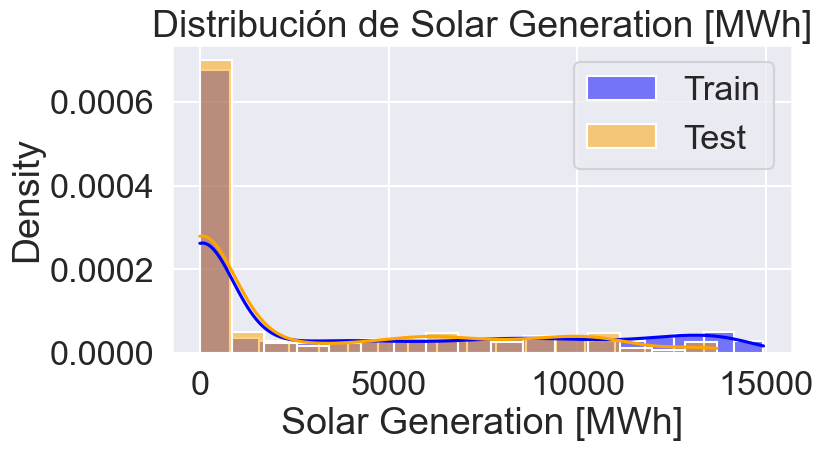

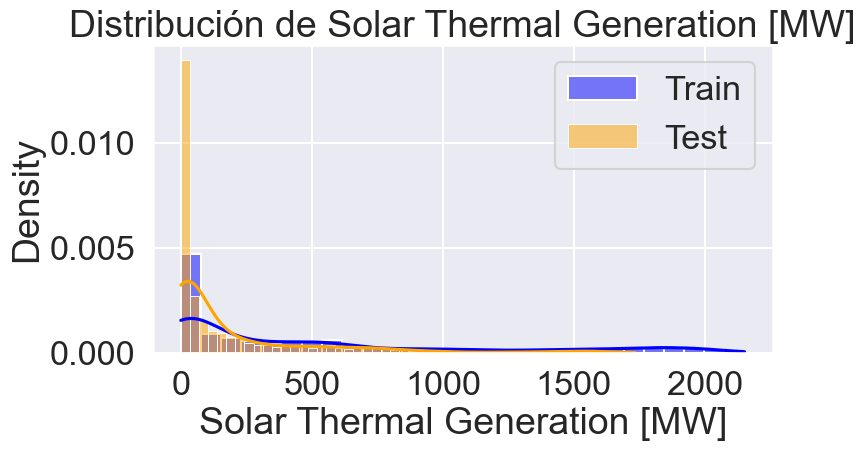

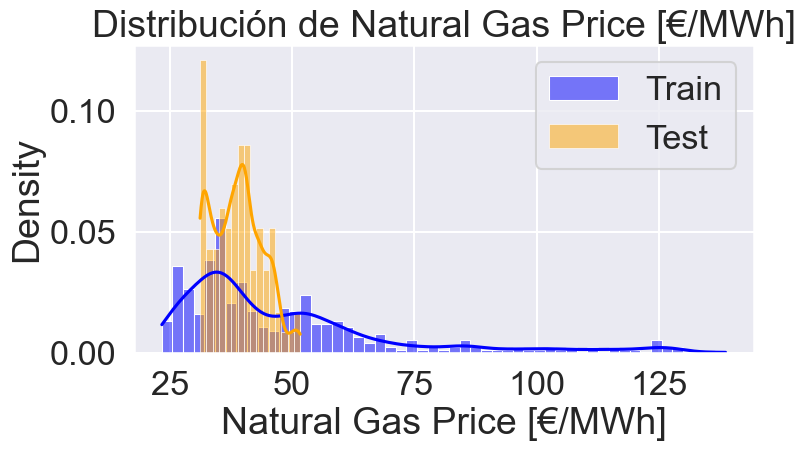

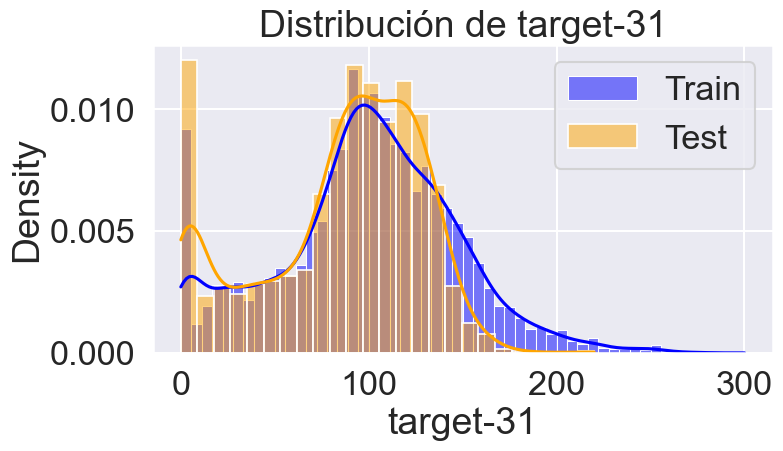

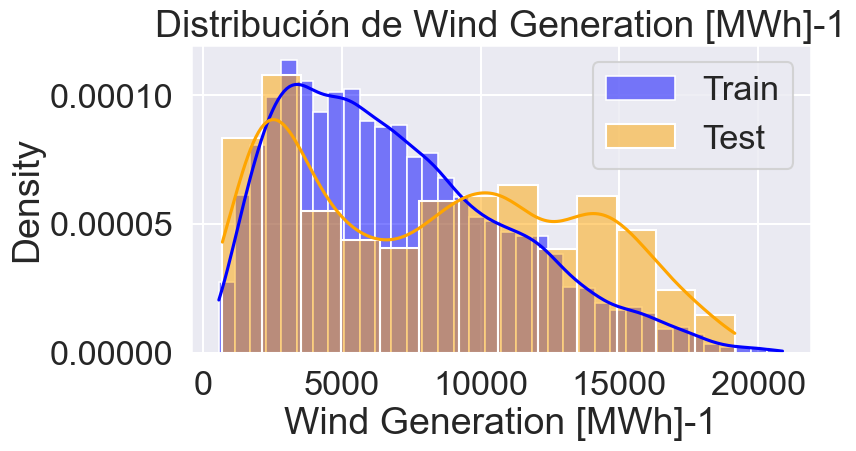

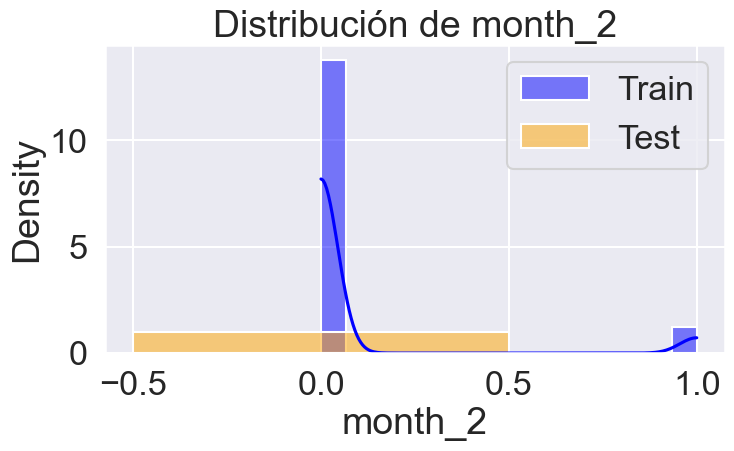

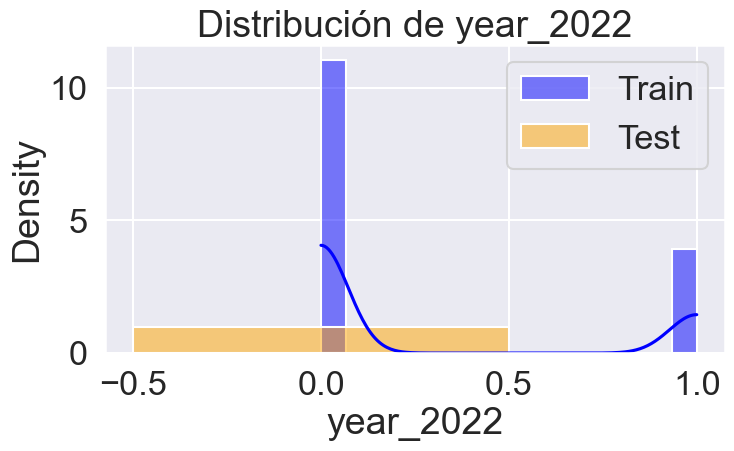

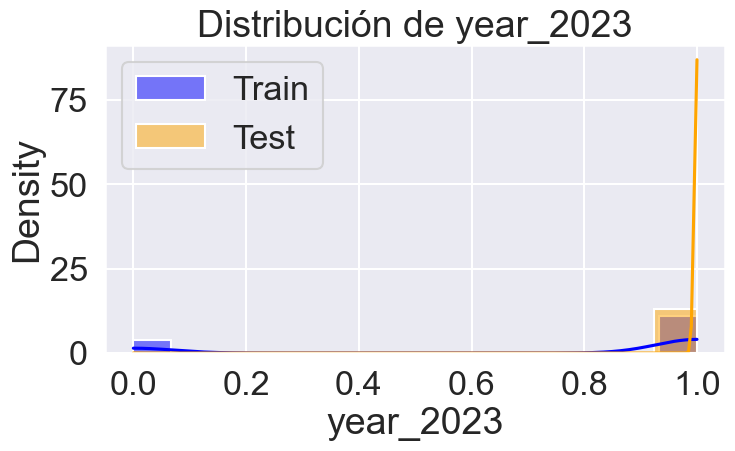

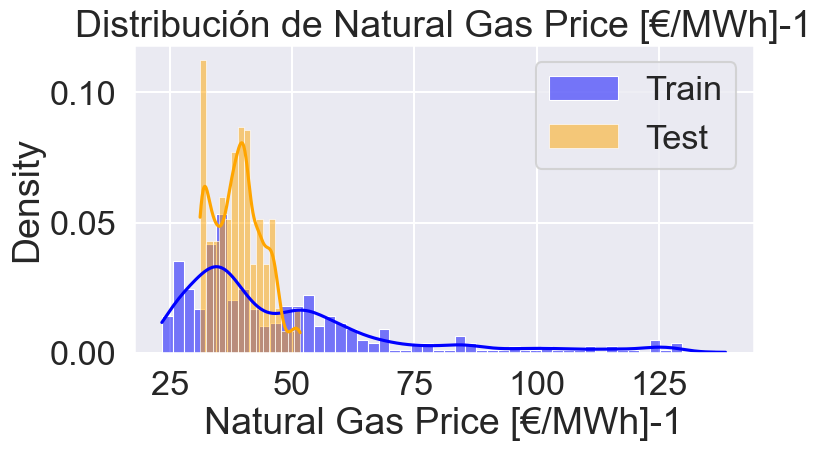

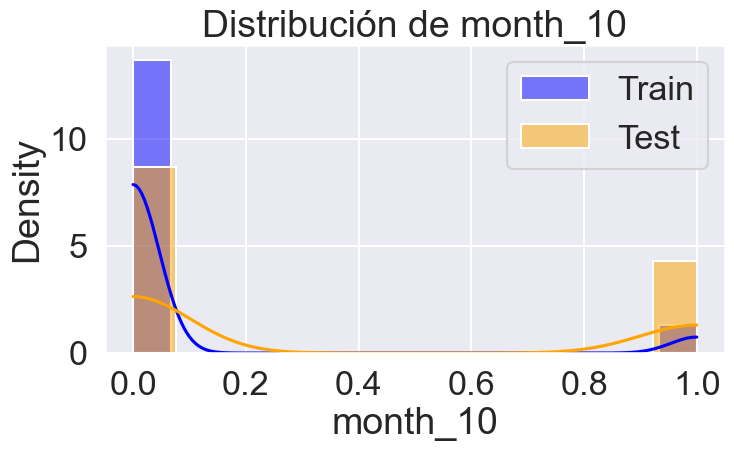

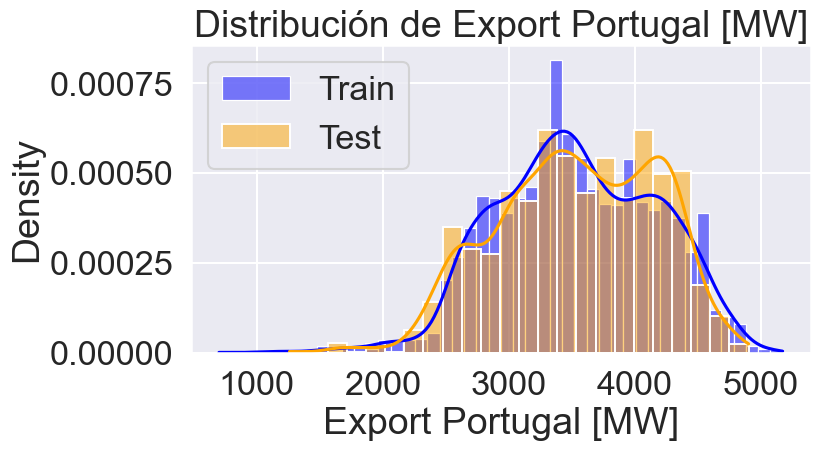

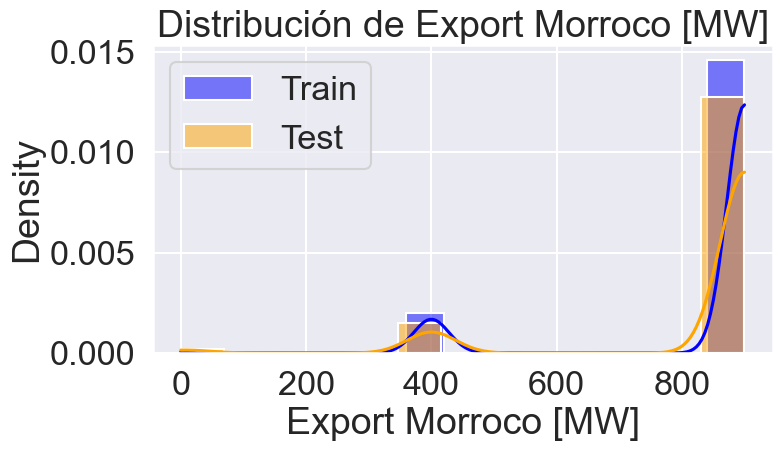

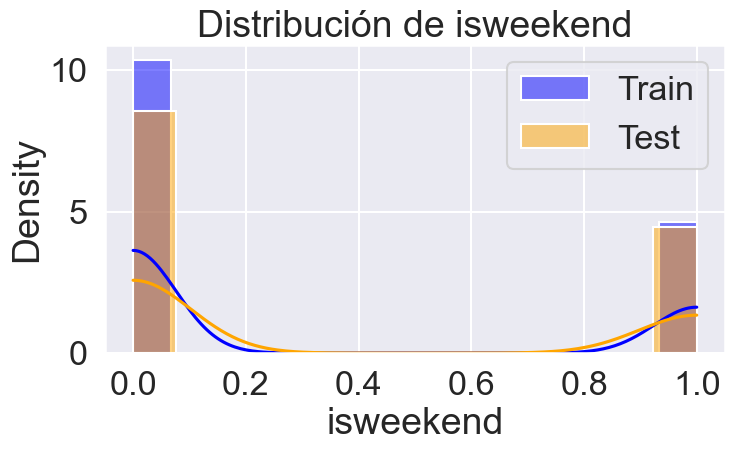

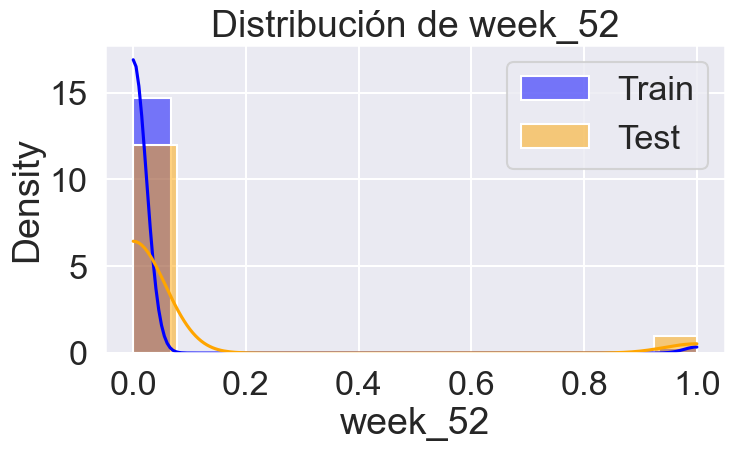

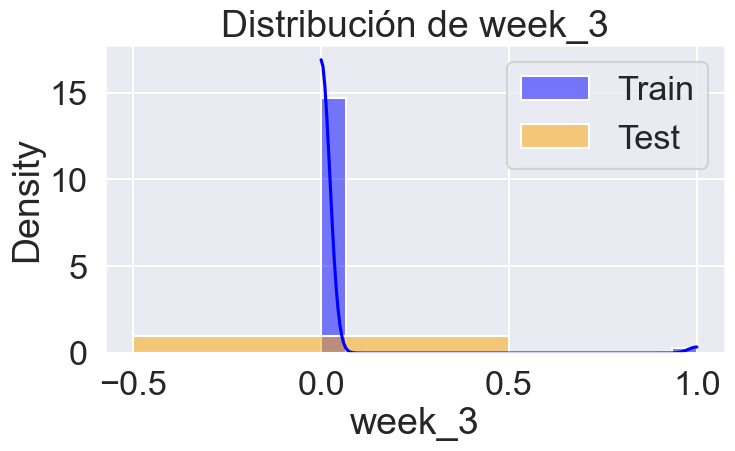

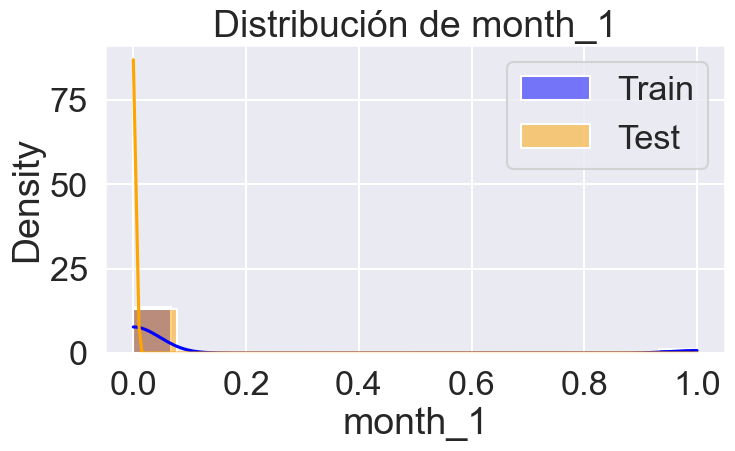

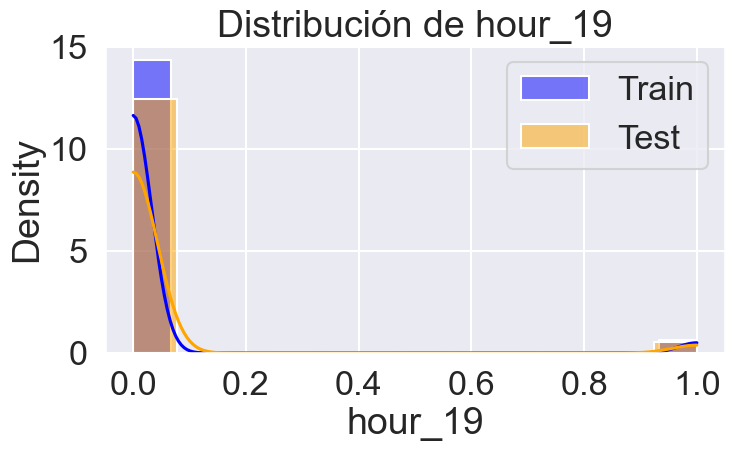

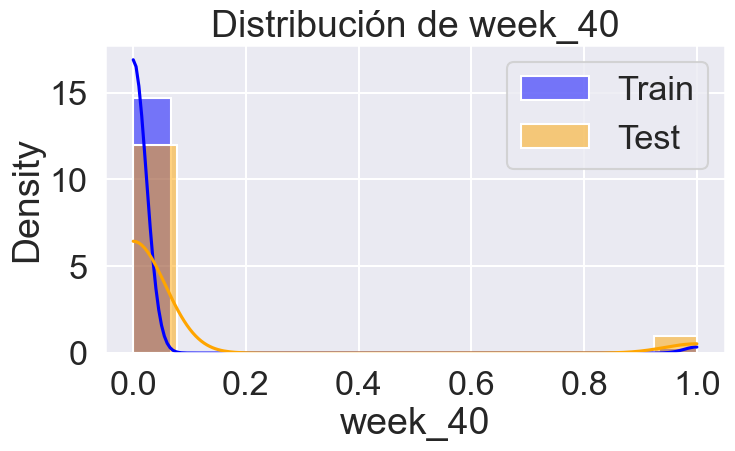

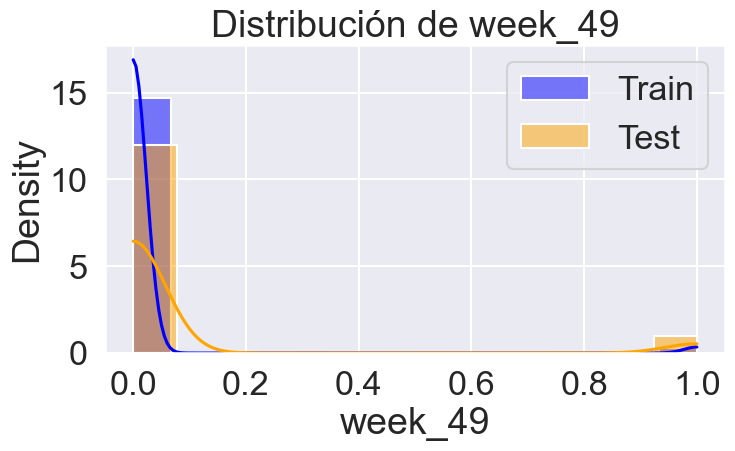

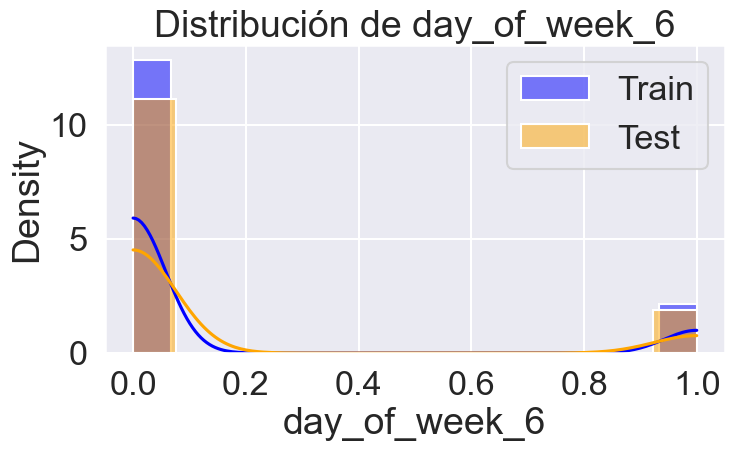

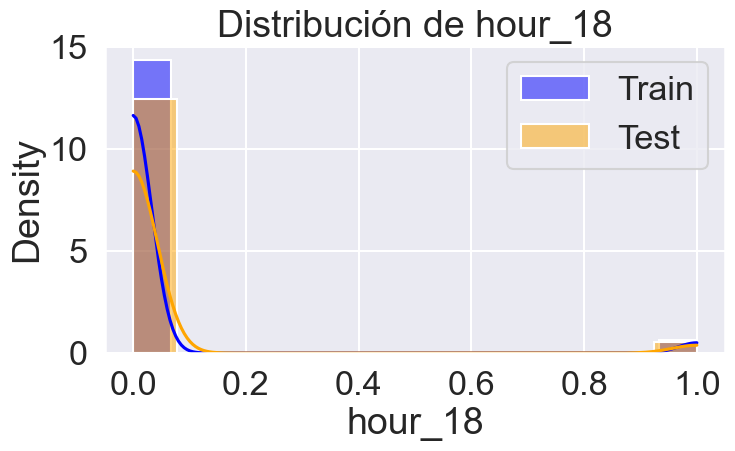

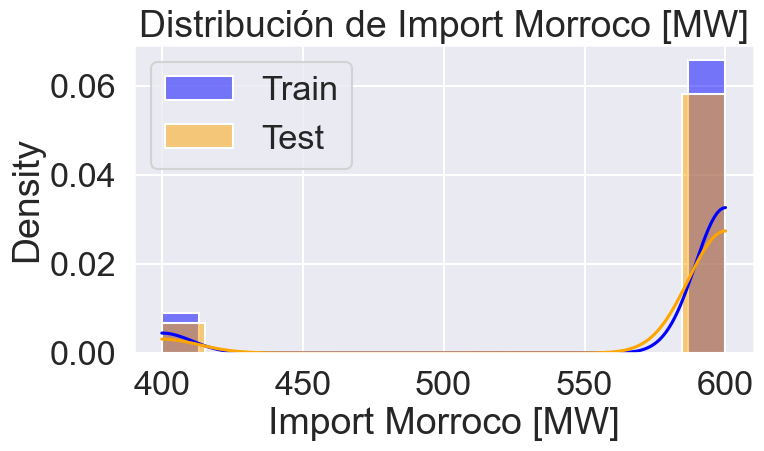

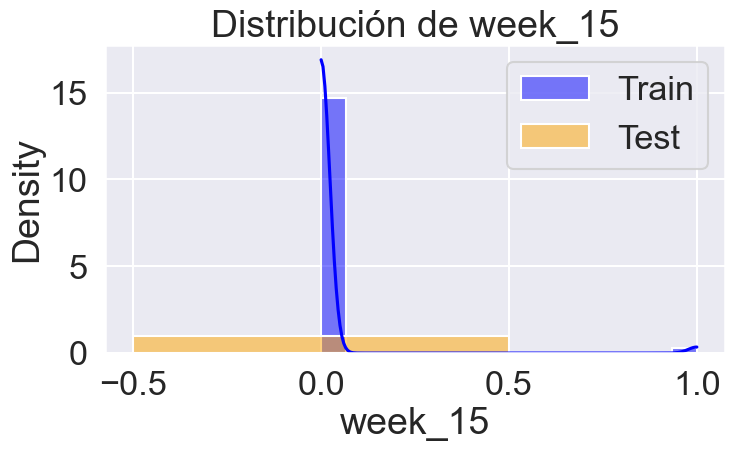

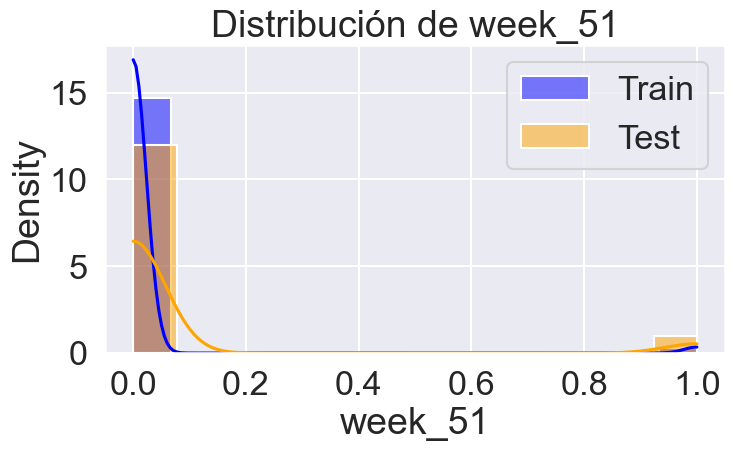

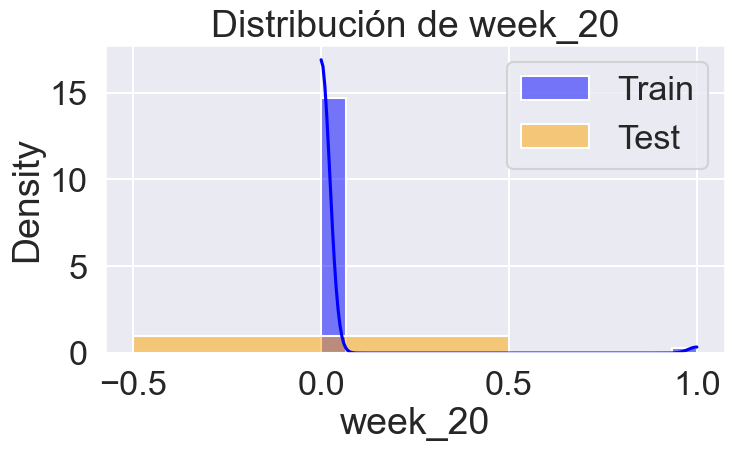

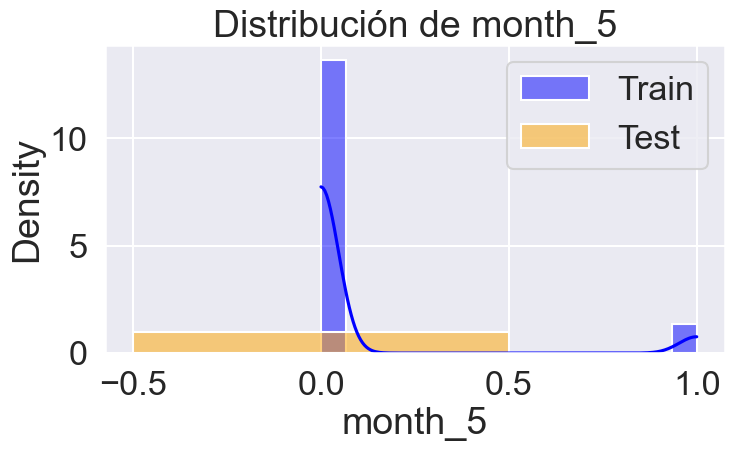

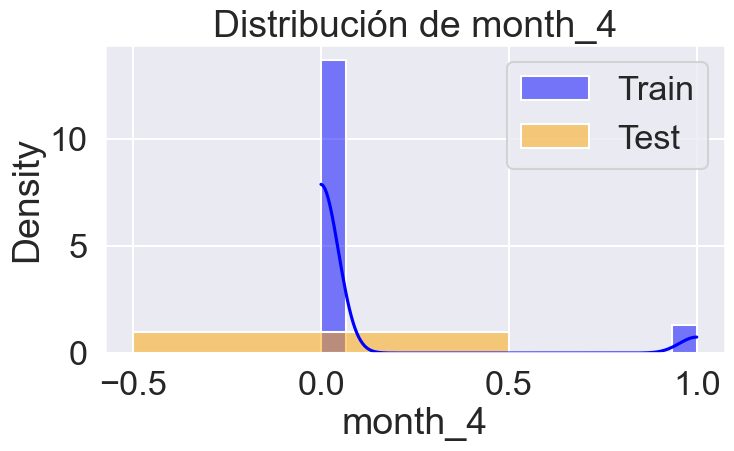

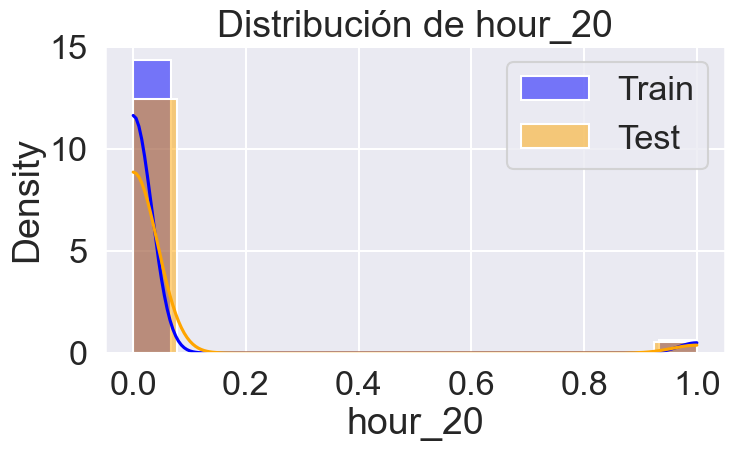

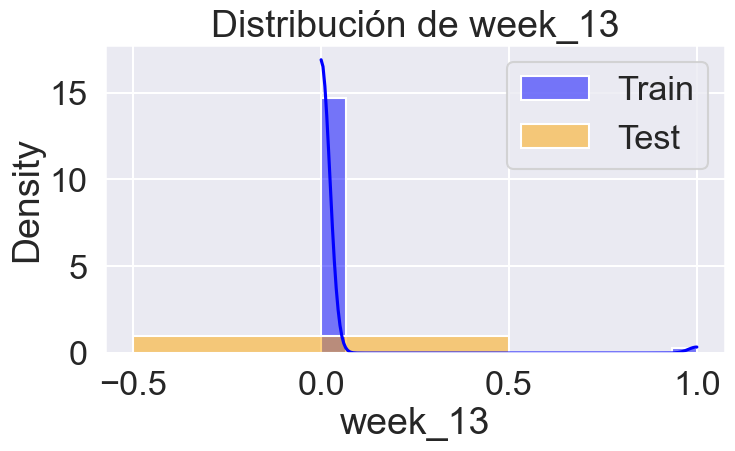

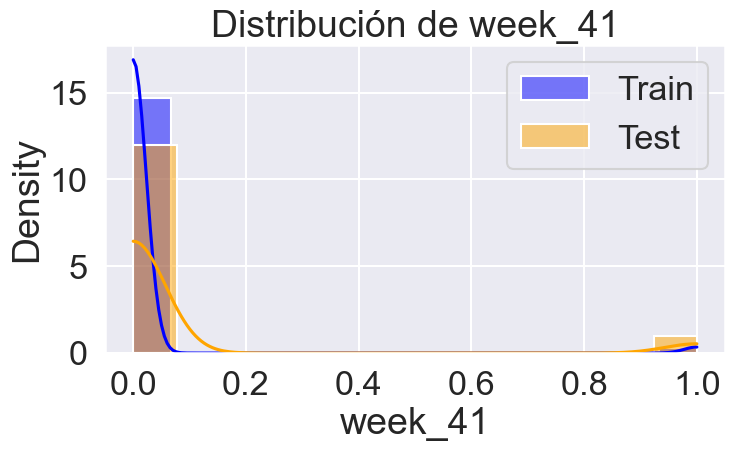

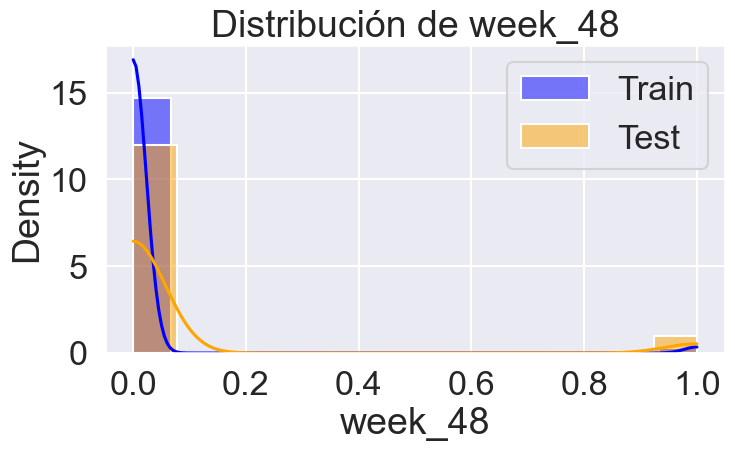

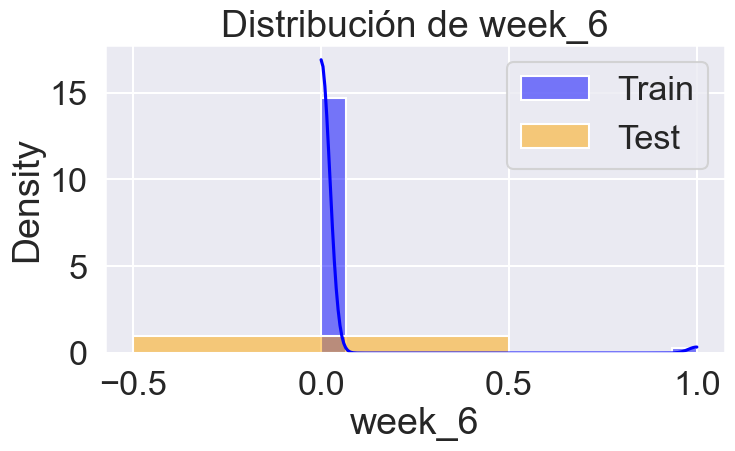

In [32]:
# Top 50 most significative features, test vs train

correlations = X_train.corrwith(y_train)
top_correlations = correlations.abs().sort_values(ascending=False).head(50)  # Selecciona las más correlacionadas

important_features = top_correlations.index.tolist()
valid_features = [feature for feature in important_features if feature in X_train.columns]

for feature in valid_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(X_train[feature], label='Train', color='blue', kde=True, stat="density", alpha=0.5)
    sns.histplot(X_test[feature], label='Test', color='orange', kde=True, stat="density", alpha=0.5)
    plt.title(f"Distribución de {feature}")
    plt.legend()
    plt.show()

In [29]:
# Define the number of folds and error metrics
num_folds = 4
error_metrics = {'neg_root_mean_squared_error', 'r2'}

# Define a dictionary with models
models = {
    ('MLP', MLPRegressor()),
    ('RFR', RandomForestRegressor()),
    ('SVR', SVR()),
    ('AdaB', AdaBoostRegressor()),
    ('GBR', GradientBoostingRegressor()),
    ('DTR', DecisionTreeRegressor()),
    ('EN', ElasticNet())
}

####### Evaluation metric:  neg_root_mean_squared_error

Training model: RFR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 4 folds...
Model: RFR, neg_root_mean_squared_error Mean: -7.7330, Std: 3.4861


Training model: GBR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 4 folds...
Model: GBR, neg_root_mean_squared_error Mean: -8.3307, Std: 3.1380


Training model: EN with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 4 folds...
Model: EN, neg_root_mean_squared_error Mean: -32.3116, Std: 12.6825


Training model: SVR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 4 folds...
Model: SVR, neg_root_mean_squared_error Mean: -23.6879, Std: 15.0688


Training model: DTR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 4 folds...
Model: DTR, neg_root_mean_squared_error Mean: -12.8504, Std: 6.4170


Training model: AdaB with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 4 folds...


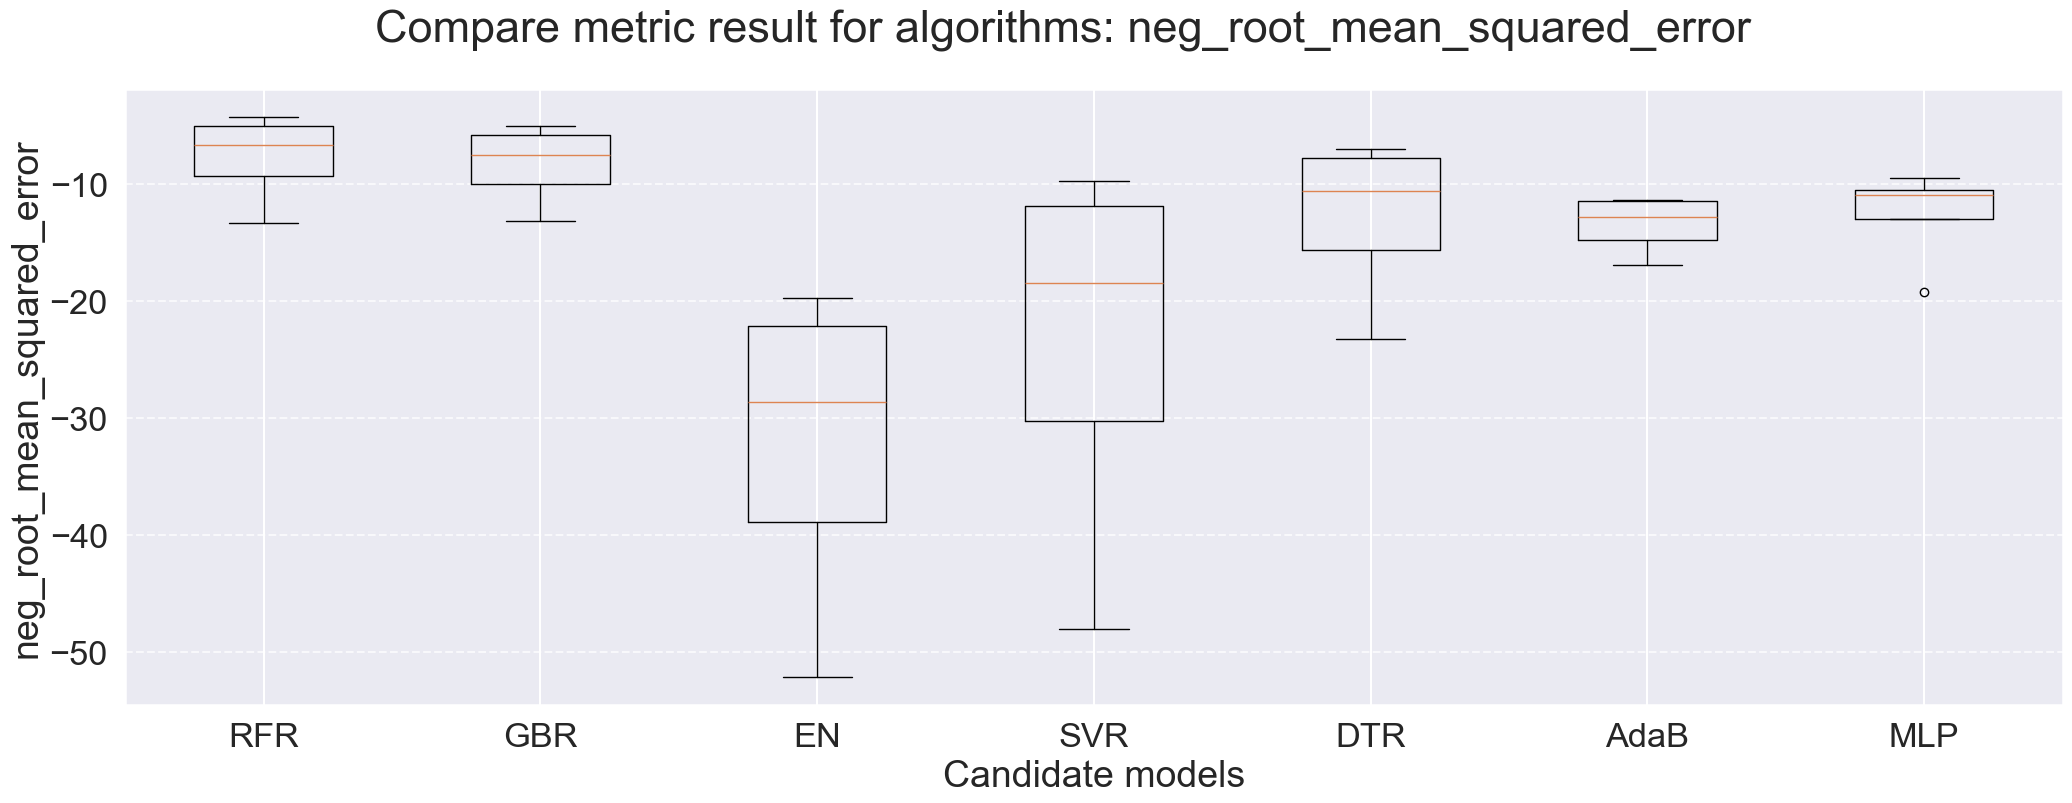

####### Evaluation metric:  r2

Training model: RFR with r2...
Performing TimeSeriesSplit with 4 folds...
Model: RFR, r2 Mean: 0.9655, Std: 0.0149


Training model: GBR with r2...
Performing TimeSeriesSplit with 4 folds...
Model: GBR, r2 Mean: 0.9595, Std: 0.0118


Training model: EN with r2...
Performing TimeSeriesSplit with 4 folds...
Model: EN, r2 Mean: 0.3935, Std: 0.1942


Training model: SVR with r2...
Performing TimeSeriesSplit with 4 folds...
Model: SVR, r2 Mean: 0.6703, Std: 0.2753


Training model: DTR with r2...
Performing TimeSeriesSplit with 4 folds...
Model: DTR, r2 Mean: 0.9057, Std: 0.0553


Training model: AdaB with r2...
Performing TimeSeriesSplit with 4 folds...
Model: AdaB, r2 Mean: 0.8844, Std: 0.0318


Training model: MLP with r2...
Performing TimeSeriesSplit with 4 folds...
Model: MLP, r2 Mean: 0.9192, Std: 0.0159



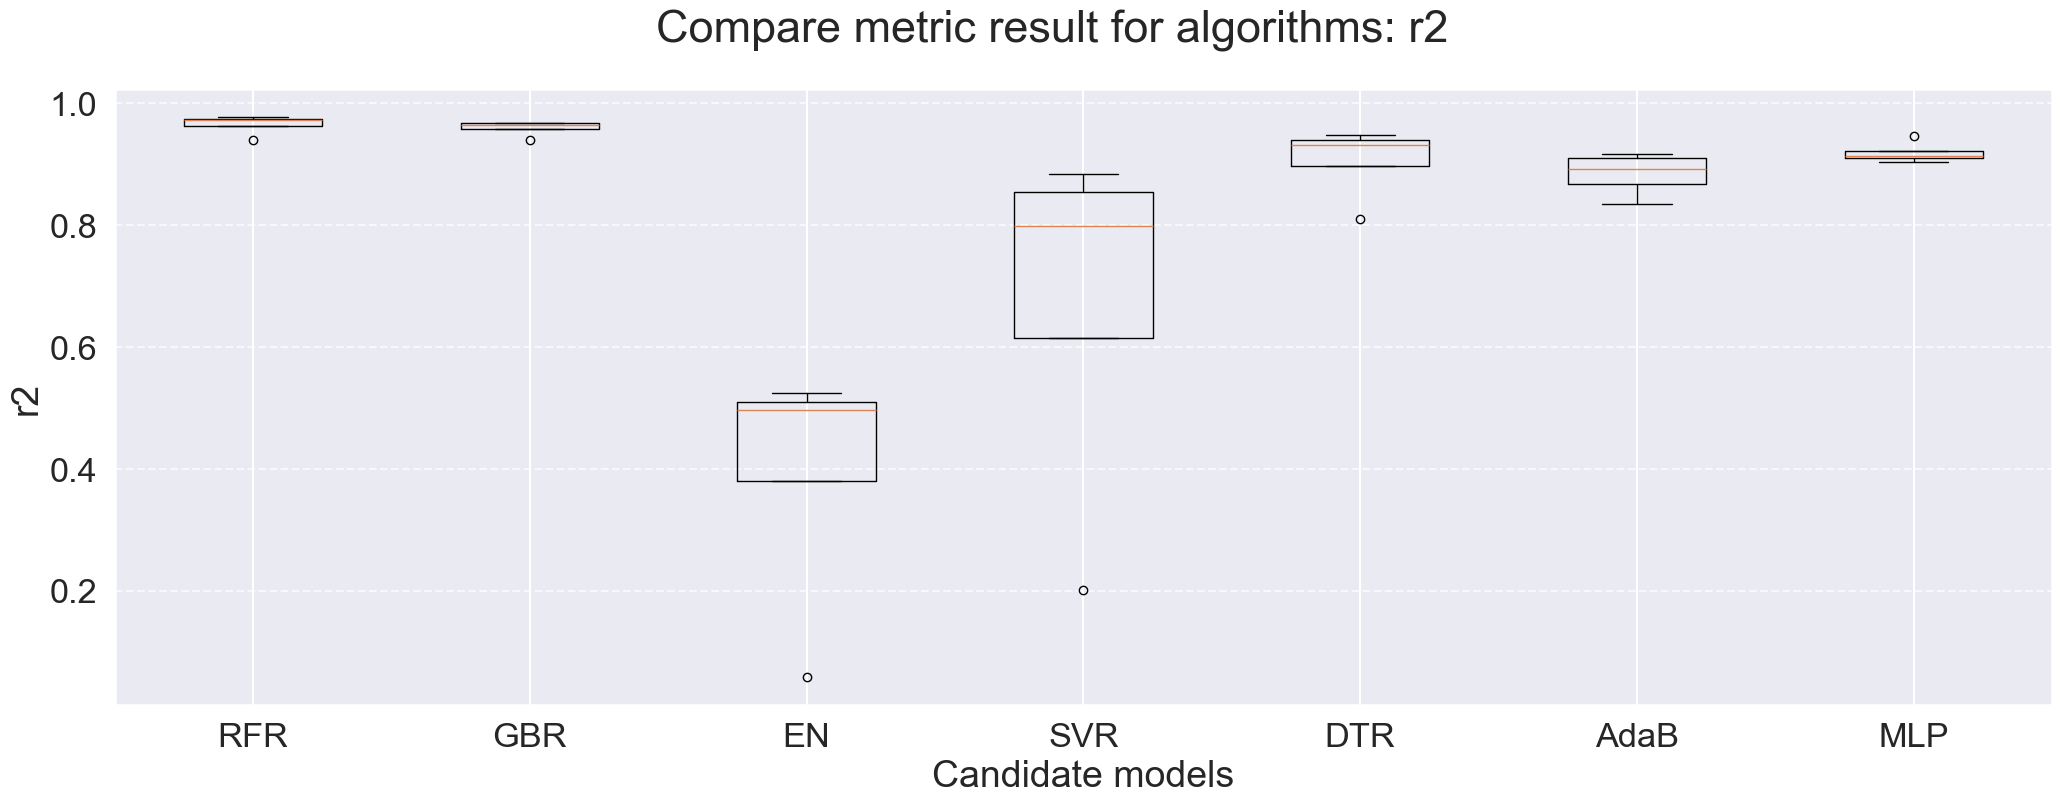

In [31]:
### CROS VALIDATION && TimeSeriesSplit between models ###

# Cross-validation training
for scoring in error_metrics:
    results = [] # store metrics results
    msg = []  # print summary of result
    names = []  # store name of the models
    print('####### Evaluation metric: ', scoring)

    for name, model in models:
        print(f'\nTraining model: {name} with {scoring}...')
        cross_validation = TimeSeriesSplit(n_splits=num_folds)

        # Start the cross-validation process and print verbose output
        print(f"Performing TimeSeriesSplit with {num_folds} folds...")

        cv_results = cross_val_score(model, X_train_scaled, y_train, cv=cross_validation, scoring=scoring)

        print(f"Model: {name}, {scoring} Mean: {cv_results.mean():.4f}, Std: {cv_results.std():.4f}\n")

        results.append(cv_results)
        names.append(name)
        resume = (name, cv_results.mean(), cv_results.std())
        msg.append(resume)

    # Compare results between algorithms
    fig = plt.figure()
    fig.suptitle('Compare metric result for algorithms: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Candidate models')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    results = []

In [33]:
#Hiperparameters XGBR

model = XGBRegressor()
scoring='r2'
params = {
    'n_estimators': [400, 600],  # Número de árboles
    'max_depth': [3,14,22],  # Máxima profundidad del árbol
    'learning_rate': [0.01],  # Tasa de aprendizaje
    'subsample': [1, 1.5],  # Submuestreo de las filas
}

# Search for the best combination of hyperparameters
cross_validation = TimeSeriesSplit(n_splits=5)
my_cv = cross_validation.split(X_val_scaled)
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=my_cv, verbose=3)
gsearch.fit(X_val_scaled, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1;, score=0.471 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1;, score=0.776 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1;, score=0.781 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1;, score=0.761 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1;, score=0.811 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1.5;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1.5;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1.5;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=400, sub

In [34]:
#Hiperparameters RFR
model = RandomForestRegressor()
scoring= 'r2'
params = {
    'n_estimators': [100, 500],
}

# Search for the best combination of hyperparameters
cross_validation = TimeSeriesSplit(n_splits=5)
my_cv = cross_validation.split(X_val_scaled)
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=my_cv, verbose=3)
gsearch.fit(X_val_scaled, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ..................n_estimators=100;, score=0.508 total time=   0.5s
[CV 2/5] END ..................n_estimators=100;, score=0.832 total time=   0.6s
[CV 3/5] END ..................n_estimators=100;, score=0.837 total time=   0.9s
[CV 4/5] END ..................n_estimators=100;, score=0.844 total time=   1.0s
[CV 5/5] END ..................n_estimators=100;, score=0.873 total time=   1.3s
[CV 1/5] END ..................n_estimators=500;, score=0.503 total time=   1.6s
[CV 2/5] END ..................n_estimators=500;, score=0.828 total time=   2.7s
[CV 3/5] END ..................n_estimators=500;, score=0.823 total time=   3.5s
[CV 4/5] END ..................n_estimators=500;, score=0.836 total time=   4.8s
[CV 5/5] END ..................n_estimators=500;, score=0.868 total time=   5.0s
Best result: 0.778647 using the following hyperparameters {'n_estimators': 100}


In [34]:
## Final Calculation ###
final_model_v1 = RandomForestRegressor(n_estimators=500, max_depth=None)
final_model_v1.fit(X_train_scaled,y_train)
y_predict_v1 = final_model_v1.predict(X_test_scaled)

from sklearn.metrics import r2_score, mean_squared_error

# Calculate R² (R-squared) score
r2 = r2_score(y_test, y_predict_v1)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, y_predict_v1)

# Print both the R² and RMSE scores
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.9811
RMSE: 32.2055


In [35]:
time_index = pd.date_range(start="2024-01-01 00:00", periods=len(y_test), freq='H')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time_index, y=y_test, mode='lines', name='y_test Values',
    line=dict(color='green', width=1.5)
))

fig.add_trace(go.Scatter(
    x=time_index, y=y_predict_v1, mode='lines', name='y_predict_v1',
    line=dict(color='red', width=1.5)
))

fig.update_layout(
    title='True vs Predicted Consumption (Comparison by Model)',
    xaxis_title='Date/Time',
    yaxis_title='Consumption (kWh)',
    template='plotly',
    hovermode='x unified',
    legend=dict(
        x=0.01, y=0.99,
        traceorder='normal',
        font=dict(family="Arial", size=12, color="black"),
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='black',
        borderwidth=1
    )
)
fig.show()

In [48]:
# Save the final model
dump(final_model_v1, 'final_model_bo.joblib')

['final_model_bo.joblib']